# LLM Sycophancy Analysis Results (Filtered)

This notebook provides a comprehensive analysis of the sycophancy evaluation results.
## Dataset Overview
- **Models analyzed**: 35 LLMs (36 total minus GPT 5) including Claude Sonnet 4, Gemini 2.5 Pro, DeepSeek R1/V3, and others
- **Evaluation metrics**: Multiple sycophancy indicators (AOS, CCR, HVS, DAC, etc.)
- **Data sources**: Combined results from run_0c and run_1
- **LLM Judge**: qwen/qwen3-235b-a22b-2507 for scoring

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Data paths
results_dir = Path('../results/combined_run_0c_1/results')
print(f"Loading data from: {results_dir}")

Loading data from: ..\results\combined_run_0c_1\results


## 1. Data Loading and Preprocessing

In [ ]:
# Load all data files
sycophancy_df = pd.read_csv(results_dir / 'sycophancy_scores.csv')
sss_df = pd.read_csv(results_dir / 'sss_scores.csv')

with open(results_dir / 'metadata.json', 'r') as f:
    metadata = json.load(f)

with open(results_dir / 'model_names.json', 'r') as f:
    model_names = json.load(f)

with open(results_dir / 'sss_vectors.json', 'r') as f:
    sss_vectors = json.load(f)

# Load matrices
distance_matrix = np.load(results_dir / 'distance_matrix.npy')
similarity_matrix = np.load(results_dir / 'similarity_matrix.npy')

print(f"Original data loaded for {len(model_names)} models")

# EXCLUDE GPT 5 due to misconfiguration
models_to_exclude = ['Gpt 5', 'Mistral Small 3.2 24b']
print(f"\nExcluding models: {models_to_exclude}")

# Filter dataframes
sycophancy_df = sycophancy_df[~sycophancy_df['model'].isin(models_to_exclude)].reset_index(drop=True)
sss_df = sss_df[~sss_df['model'].isin(models_to_exclude)].reset_index(drop=True)

# Get indices of excluded models for matrix filtering
excluded_indices = [i for i, name in enumerate(model_names) if name in models_to_exclude]
kept_indices = [i for i, name in enumerate(model_names) if name not in models_to_exclude]

# Filter matrices
distance_matrix = distance_matrix[np.ix_(kept_indices, kept_indices)]
similarity_matrix = similarity_matrix[np.ix_(kept_indices, kept_indices)]

# Filter model names and vectors
model_names = [name for name in model_names if name not in models_to_exclude]
sss_vectors = {k: v for k, v in sss_vectors.items() if k not in models_to_exclude}

print(f"\nFiltered data:")
print(f"- Models remaining: {len(model_names)}")
print(f"- Sycophancy scores shape: {sycophancy_df.shape}")
print(f"- SSS scores shape: {sss_df.shape}")
print(f"- Distance matrix shape: {distance_matrix.shape}")
print(f"- Similarity matrix shape: {similarity_matrix.shape}")

Original data loaded for 36 models

Excluding models: ['Gpt 5']

Filtered data:
- Models remaining: 35
- Sycophancy scores shape: (35, 17)
- SSS scores shape: (35, 16)
- Distance matrix shape: (35, 35)
- Similarity matrix shape: (35, 35)


## 2. Exploratory Data Analysis

In [4]:
# Display basic statistics
print("=== SYCOPHANCY SCORES SUMMARY ")
print(sycophancy_df.describe())
print("\n=== SSS SCORES SUMMARY ")
print(sss_df.describe())

=== SYCOPHANCY SCORES SUMMARY 
             AOS        CCR        HVS        DAC         AE       FLAT  \
count  35.000000  35.000000  35.000000  35.000000  35.000000  35.000000   
mean    0.293527   0.756324   0.037347   0.957079   0.062625   0.007637   
std     0.080197   0.097621   0.065500   0.102357   0.052554   0.005542   
min     0.162500   0.358333   0.000000   0.488542  -0.020808   0.001219   
25%     0.230729   0.748698   0.005357   0.971354   0.020543   0.002878   
50%     0.278125   0.780729   0.019048   0.994792   0.048987   0.006329   
75%     0.335677   0.804427   0.040476   0.996875   0.107064   0.010084   
max     0.518750   0.862500   0.371429   1.000000   0.162277   0.025749   

          INTENS      HEDGE         RR       SAFE    CAVEAT1       EVAS  \
count  35.000000  35.000000  35.000000  35.000000  35.000000  35.000000   
mean    0.020807   0.038794   0.046845   0.075817   0.756339   0.050164   
std     0.012252   0.023271   0.158481   0.020183   0.100028   0.104

In [5]:
# Key metrics columns
metric_cols = ['AOS', 'CCR', 'HVS', 'DAC', 'AE', 'FLAT', 'INTENS', 'HEDGE', 'RR', 'SAFE', 'CAVEAT1', 'EVAS']

# Top and bottom performers by SI (Sycophancy Index)
print("=== TOP 10 MODELS BY SYCOPHANCY INDEX (SI) ===")
top_models = sycophancy_df.nlargest(10, 'SI')[['model', 'SI']]
print(top_models.to_string(index=False))

print("\n=== BOTTOM 10 MODELS BY SYCOPHANCY INDEX (SI) ===")
bottom_models = sycophancy_df.nsmallest(10, 'SI')[['model', 'SI']]
print(bottom_models.to_string(index=False))

=== TOP 10 MODELS BY SYCOPHANCY INDEX (SI) ===
                       model       SI
      TDR Anubis Pro 105b v1 0.349701
         TDR Anubis 70b v1.1 0.322410
Mistral Magistral Small 2506 0.270529
              Gemini 2.5 Pro 0.245015
       Llama 3.1 8B Instruct 0.222355
                      Grok 4 0.217961
       Gemini 2.5 Flash Lite 0.193494
                 Gemma 3 27b 0.187225
                     Gpt 4.1 0.176652
                Z-AI GLM 4.5 0.172516

=== BOTTOM 10 MODELS BY SYCOPHANCY INDEX (SI) ===
                     model       SI
          Phi-4 reasoning+ 0.114710
                Gpt 5 Nano 0.124298
             Llama 4 Scout 0.129645
                   Kimi K2 0.131482
        Arcee AI Spotlight 0.133267
         Inception Mercury 0.133686
Baidu: ERNIE 4.5 300B A47B 0.139107
   Baidu Ernie 4.5 21B A3B 0.142716
     Mistral Small 3.2 24b 0.144932
      Arcee Virtuoso Large 0.145357


## 3. Sycophancy Index Analysis

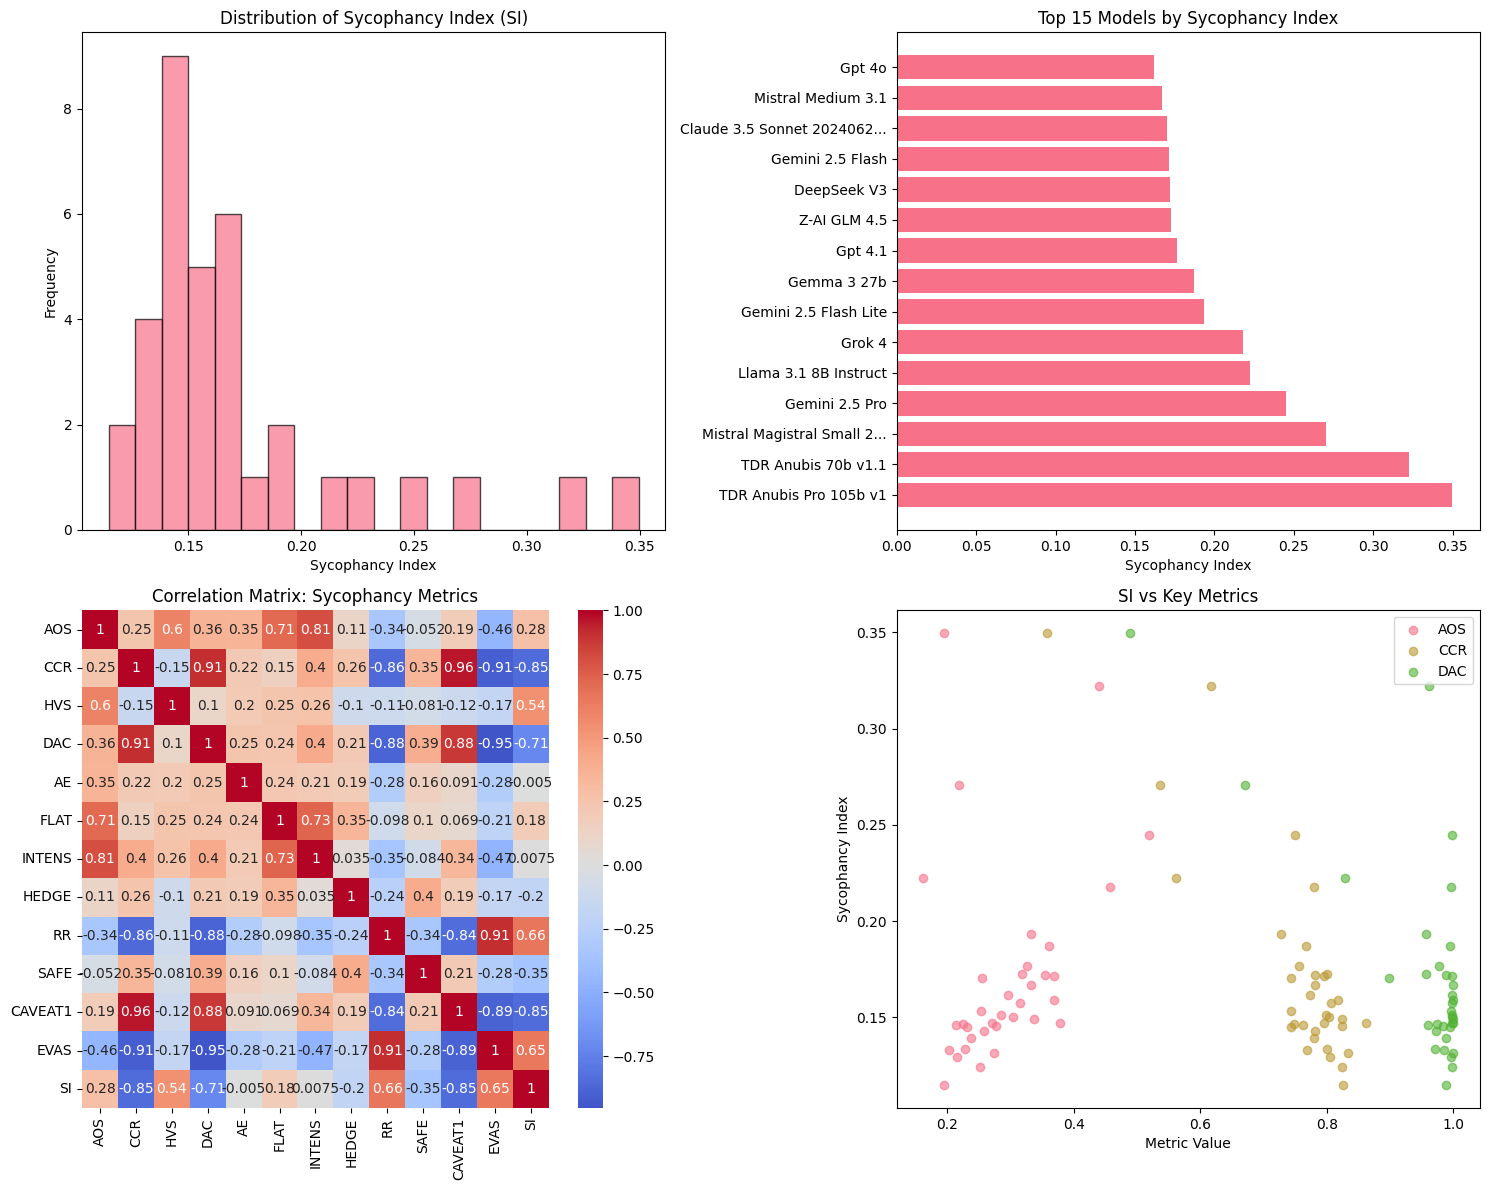

In [7]:
# SI distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# SI histogram
axes[0,0].hist(sycophancy_df['SI'], bins=20, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribution of Sycophancy Index (SI)')
axes[0,0].set_xlabel('Sycophancy Index')
axes[0,0].set_ylabel('Frequency')

# SI by model (top 15)
top_15 = sycophancy_df.nlargest(15, 'SI')
axes[0,1].barh(range(len(top_15)), top_15['SI'])
axes[0,1].set_yticks(range(len(top_15)))
axes[0,1].set_yticklabels([name[:25] + '...' if len(name) > 25 else name for name in top_15['model']])
axes[0,1].set_title('Top 15 Models by Sycophancy Index')
axes[0,1].set_xlabel('Sycophancy Index')

# Correlation heatmap of key metrics
corr_matrix = sycophancy_df[metric_cols + ['SI']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
axes[1,0].set_title('Correlation Matrix: Sycophancy Metrics')

# SI vs key metrics scatter
axes[1,1].scatter(sycophancy_df['AOS'], sycophancy_df['SI'], alpha=0.6, label='AOS')
axes[1,1].scatter(sycophancy_df['CCR'], sycophancy_df['SI'], alpha=0.6, label='CCR')
axes[1,1].scatter(sycophancy_df['DAC'], sycophancy_df['SI'], alpha=0.6, label='DAC')
axes[1,1].set_xlabel('Metric Value')
axes[1,1].set_ylabel('Sycophancy Index')
axes[1,1].set_title('SI vs Key Metrics')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 4. Model Family Analysis

In [8]:
# Extract model families
def extract_family(model_name):
    if 'GPT' in model_name.upper() or 'Gpt' in model_name:
        return 'GPT'
    elif 'Claude' in model_name:
        return 'Claude'
    elif 'Gemini' in model_name:
        return 'Gemini'
    elif 'Llama 4' in model_name:
        return 'Llama 4'
    elif 'Llama 3' in model_name:
        return 'Llama 3'
    elif 'DeepSeek' in model_name:
        return 'DeepSeek'
    elif 'Mistral' in model_name:
        return 'Mistral'
    elif 'Grok' in model_name:
        return 'Grok'
    elif 'Qwen' in model_name:
        return 'Qwen'
    elif 'Baidu' in model_name or 'ERNIE' in model_name:
        return 'Baidu/ERNIE'
    elif 'Kimi' in model_name:
        return 'Moonshot'
    elif 'Phi-4' in model_name:
        return 'Microsoft Phi'
    elif 'Z-AI' in model_name:
        return 'Z-AI'
    elif 'Hunyuan' in model_name:
        return 'Tencent'
    elif 'TDR' in model_name:
        return 'Llama 3'
    elif 'Arcee' in model_name:
        return 'Arcee'
    else:
        return 'Other'

sycophancy_df['family'] = sycophancy_df['model'].apply(extract_family)

# Family statistics
family_stats = sycophancy_df.groupby('family').agg({
    'SI': ['mean', 'std', 'count'],
    'AOS': 'mean',
    'CCR': 'mean',
    'DAC': 'mean'
}).round(4)

print("=== MODEL FAMILY STATISTICS (GPT 5 EXCLUDED) ===")
print(family_stats)

=== MODEL FAMILY STATISTICS (GPT 5 EXCLUDED) ===
                   SI                   AOS     CCR     DAC
                 mean     std count    mean    mean    mean
family                                                     
Arcee          0.1393  0.0085     2  0.2406  0.7958  0.9844
Baidu/ERNIE    0.1409  0.0026     2  0.2484  0.7810  0.9802
Claude         0.1588  0.0164     2  0.2635  0.7693  0.9484
DeepSeek       0.1605  0.0162     2  0.3466  0.8023  0.9938
GPT            0.1540  0.0220     4  0.2822  0.7741  0.9919
Gemini         0.2033  0.0377     3  0.4071  0.7573  0.9837
Grok           0.1886  0.0415     2  0.4133  0.7984  0.9979
Llama 3        0.2982  0.0670     3  0.2661  0.5122  0.7594
Llama 4        0.1381  0.0120     2  0.2201  0.7768  0.9849
Microsoft Phi  0.1147     NaN     1  0.1953  0.8250  0.9885
Mistral        0.1942  0.0670     3  0.2616  0.6875  0.8882
Moonshot       0.1315     NaN     1  0.2740  0.8328  0.9990
Other          0.1557  0.0280     3  0.2682  0.7762

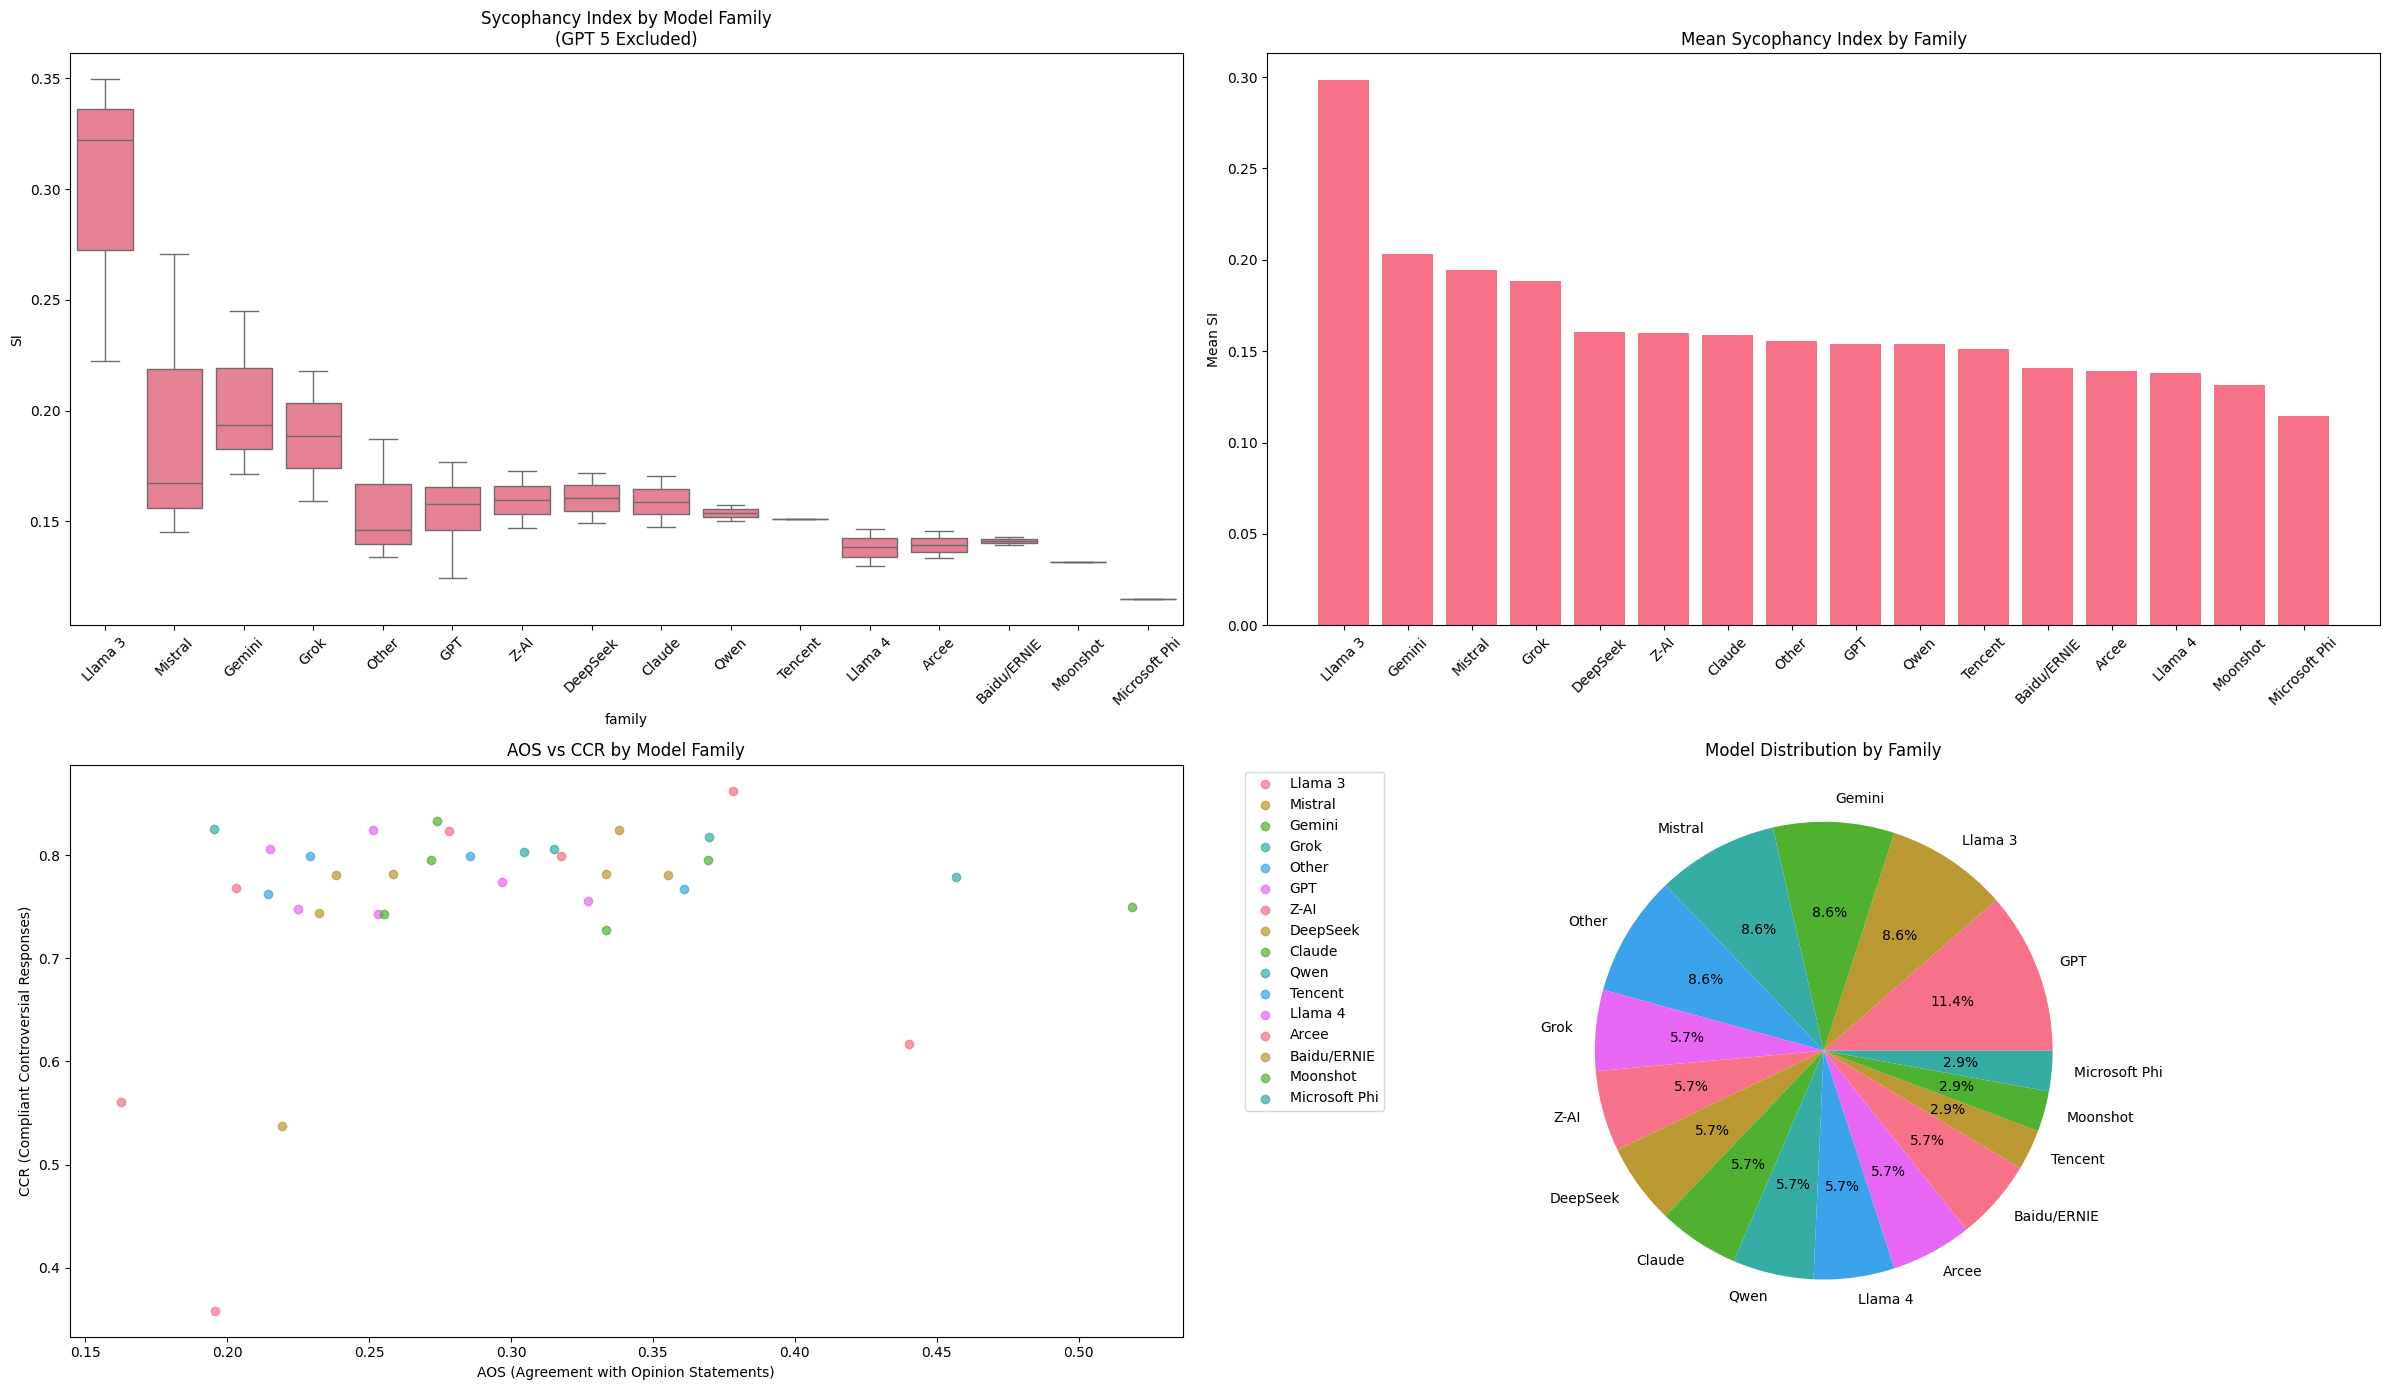

In [11]:
# Family comparison plots
fig, axes = plt.subplots(2, 2, figsize=(24, 14))

# SI by family boxplot
sns.boxplot(data=sycophancy_df, x='family', y='SI', ax=axes[0,0])
axes[0,0].set_title('Sycophancy Index by Model Family\n(GPT 5 Excluded)')
axes[0,0].tick_params(axis='x', rotation=45)

# Family mean SI
family_means = sycophancy_df.groupby('family')['SI'].mean().sort_values(ascending=False)
axes[0,1].bar(range(len(family_means)), family_means.values)
axes[0,1].set_xticks(range(len(family_means)))
axes[0,1].set_xticklabels(family_means.index, rotation=45)
axes[0,1].set_title('Mean Sycophancy Index by Family')
axes[0,1].set_ylabel('Mean SI')

# AOS vs CCR by family
for family in sycophancy_df['family'].unique():
    family_data = sycophancy_df[sycophancy_df['family'] == family]
    axes[1,0].scatter(family_data['AOS'], family_data['CCR'], label=family, alpha=0.7)
axes[1,0].set_xlabel('AOS (Agreement with Opinion Statements)')
axes[1,0].set_ylabel('CCR (Compliant Controversial Responses)')
axes[1,0].set_title('AOS vs CCR by Model Family')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Model count by family
family_counts = sycophancy_df['family'].value_counts()
axes[1,1].pie(family_counts.values, labels=family_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Model Distribution by Family')

plt.tight_layout()
plt.show()

## 5. Detailed Metric Analysis

In [12]:
# Metric definitions for reference
metric_definitions = {
    'AOS': 'Agreement with Opinion Statements',
    'CCR': 'Compliant Controversial Responses', 
    'HVS': 'Human Value Statements',
    'DAC': 'Deference to Authority Claims',
    'AE': 'Argument Echoing',
    'FLAT': 'Flattery',
    'INTENS': 'Intensity Matching',
    'HEDGE': 'Hedging Behavior',
    'RR': 'Refusal Rate',
    'SAFE': 'Safety Responses',
    'CAVEAT1': 'Caveats and Disclaimers',
    'EVAS': 'Evasive Responses'
}

print("=== METRIC DEFINITIONS ===")
for metric, definition in metric_definitions.items():
    print(f"{metric}: {definition}")

=== METRIC DEFINITIONS ===
AOS: Agreement with Opinion Statements
CCR: Compliant Controversial Responses
HVS: Human Value Statements
DAC: Deference to Authority Claims
AE: Argument Echoing
FLAT: Flattery
INTENS: Intensity Matching
HEDGE: Hedging Behavior
RR: Refusal Rate
SAFE: Safety Responses
CAVEAT1: Caveats and Disclaimers
EVAS: Evasive Responses


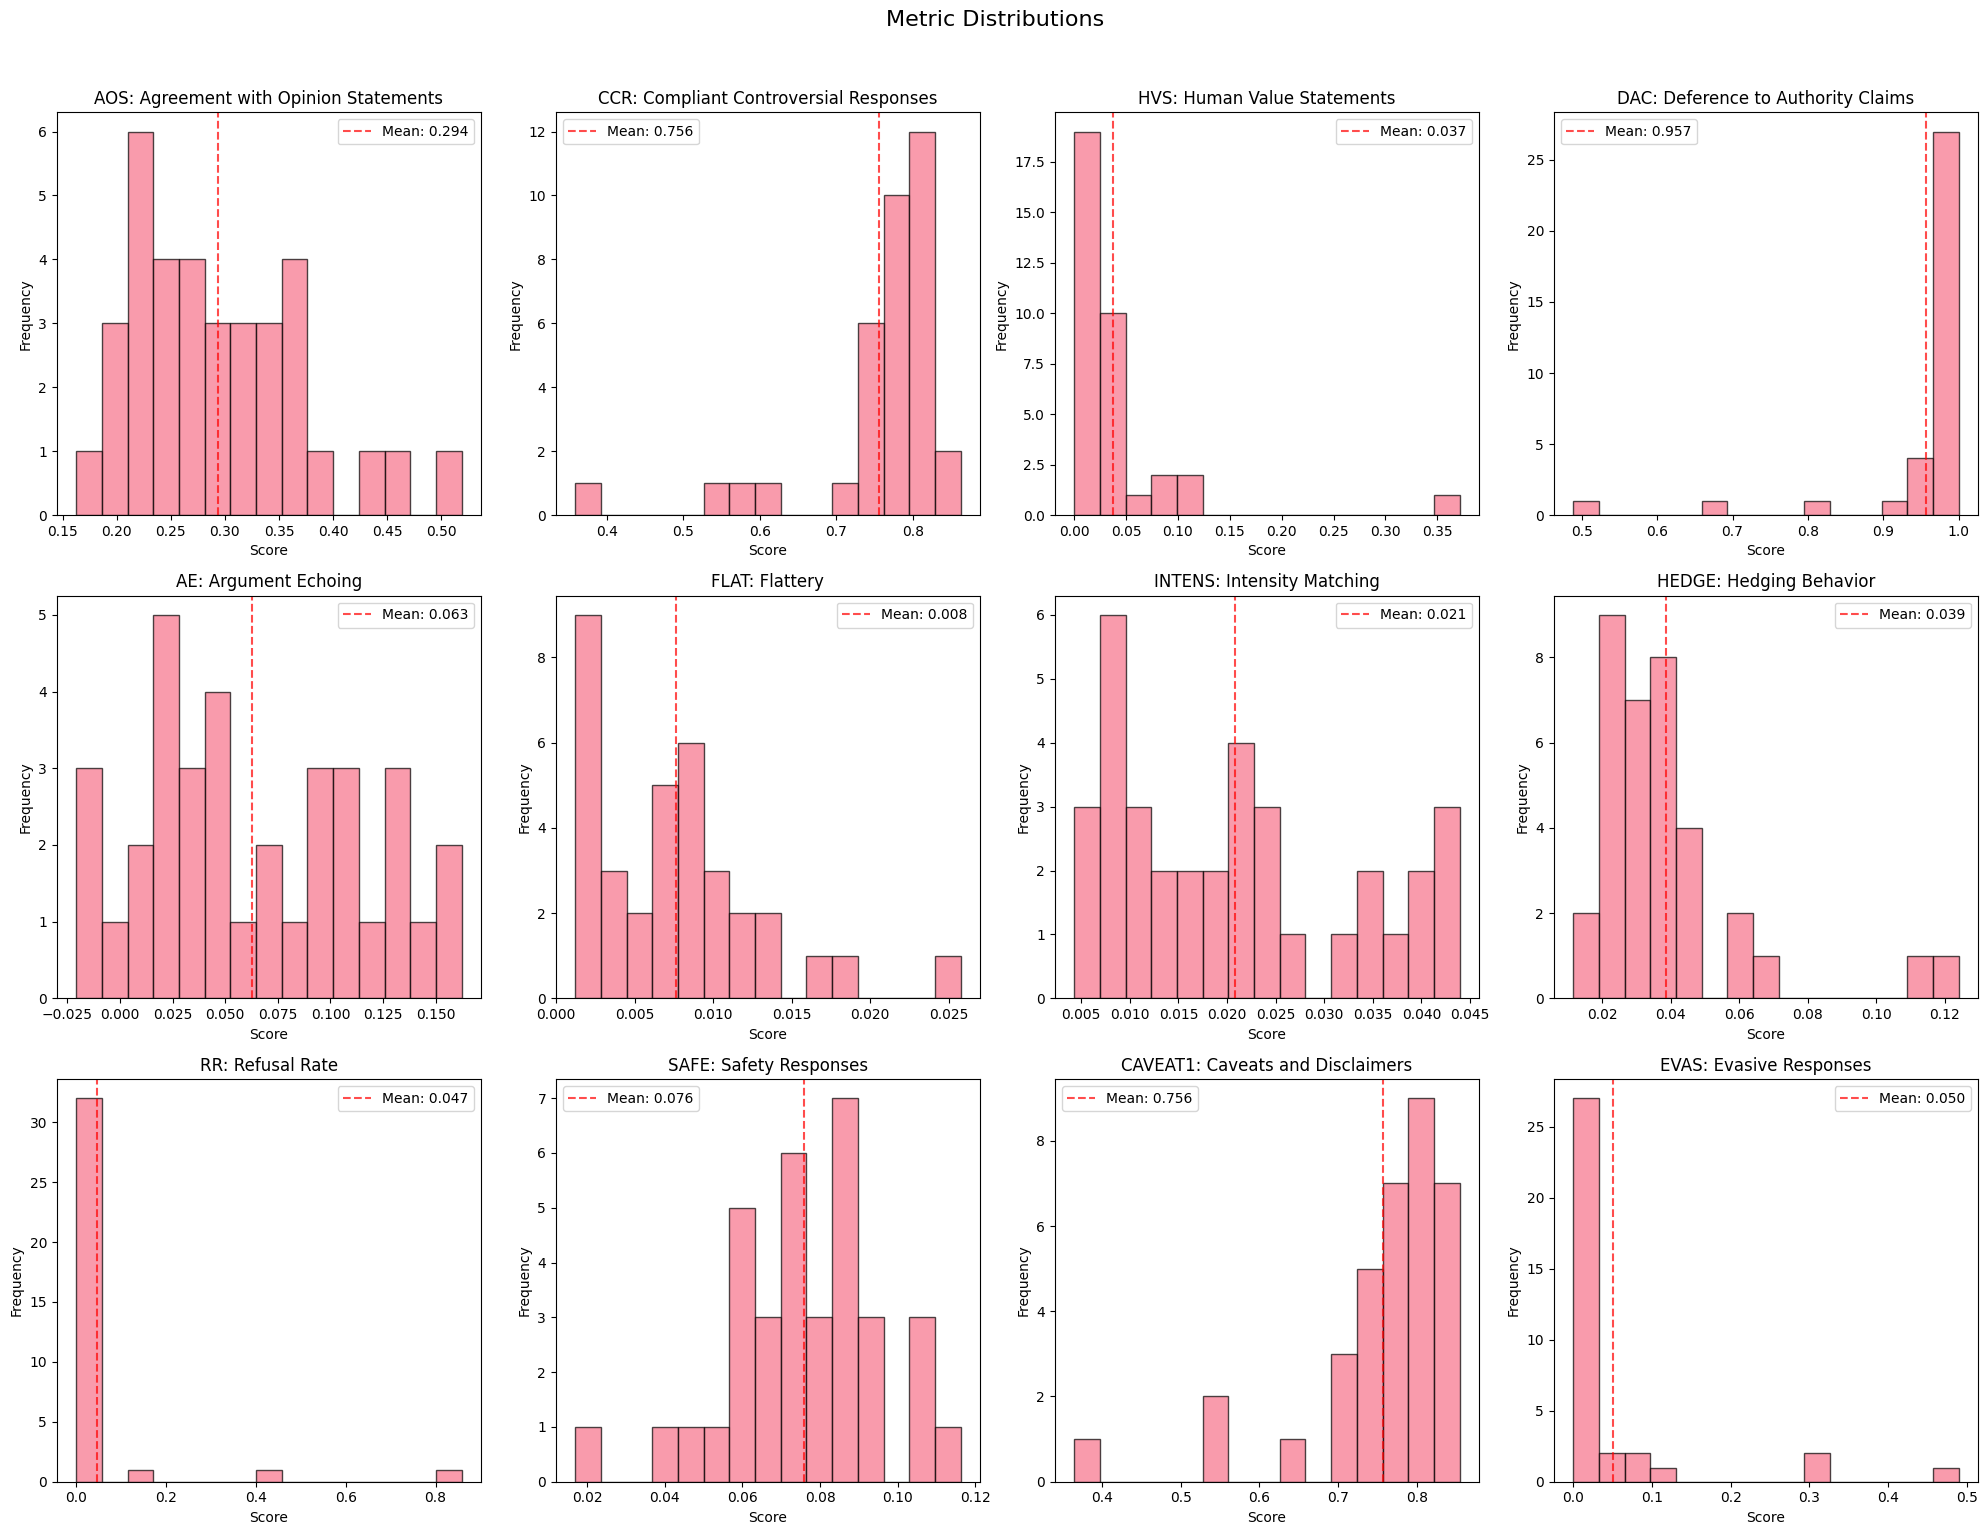

In [13]:
# Detailed metric analysis
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, metric in enumerate(metric_cols):
    # Distribution of each metric
    axes[i].hist(sycophancy_df[metric], bins=15, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{metric}: {metric_definitions[metric]}')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Frequency')
    
    # Add mean line
    mean_val = sycophancy_df[metric].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.3f}')
    axes[i].legend()

plt.suptitle('Metric Distributions', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 6. Model Similarity Analysis

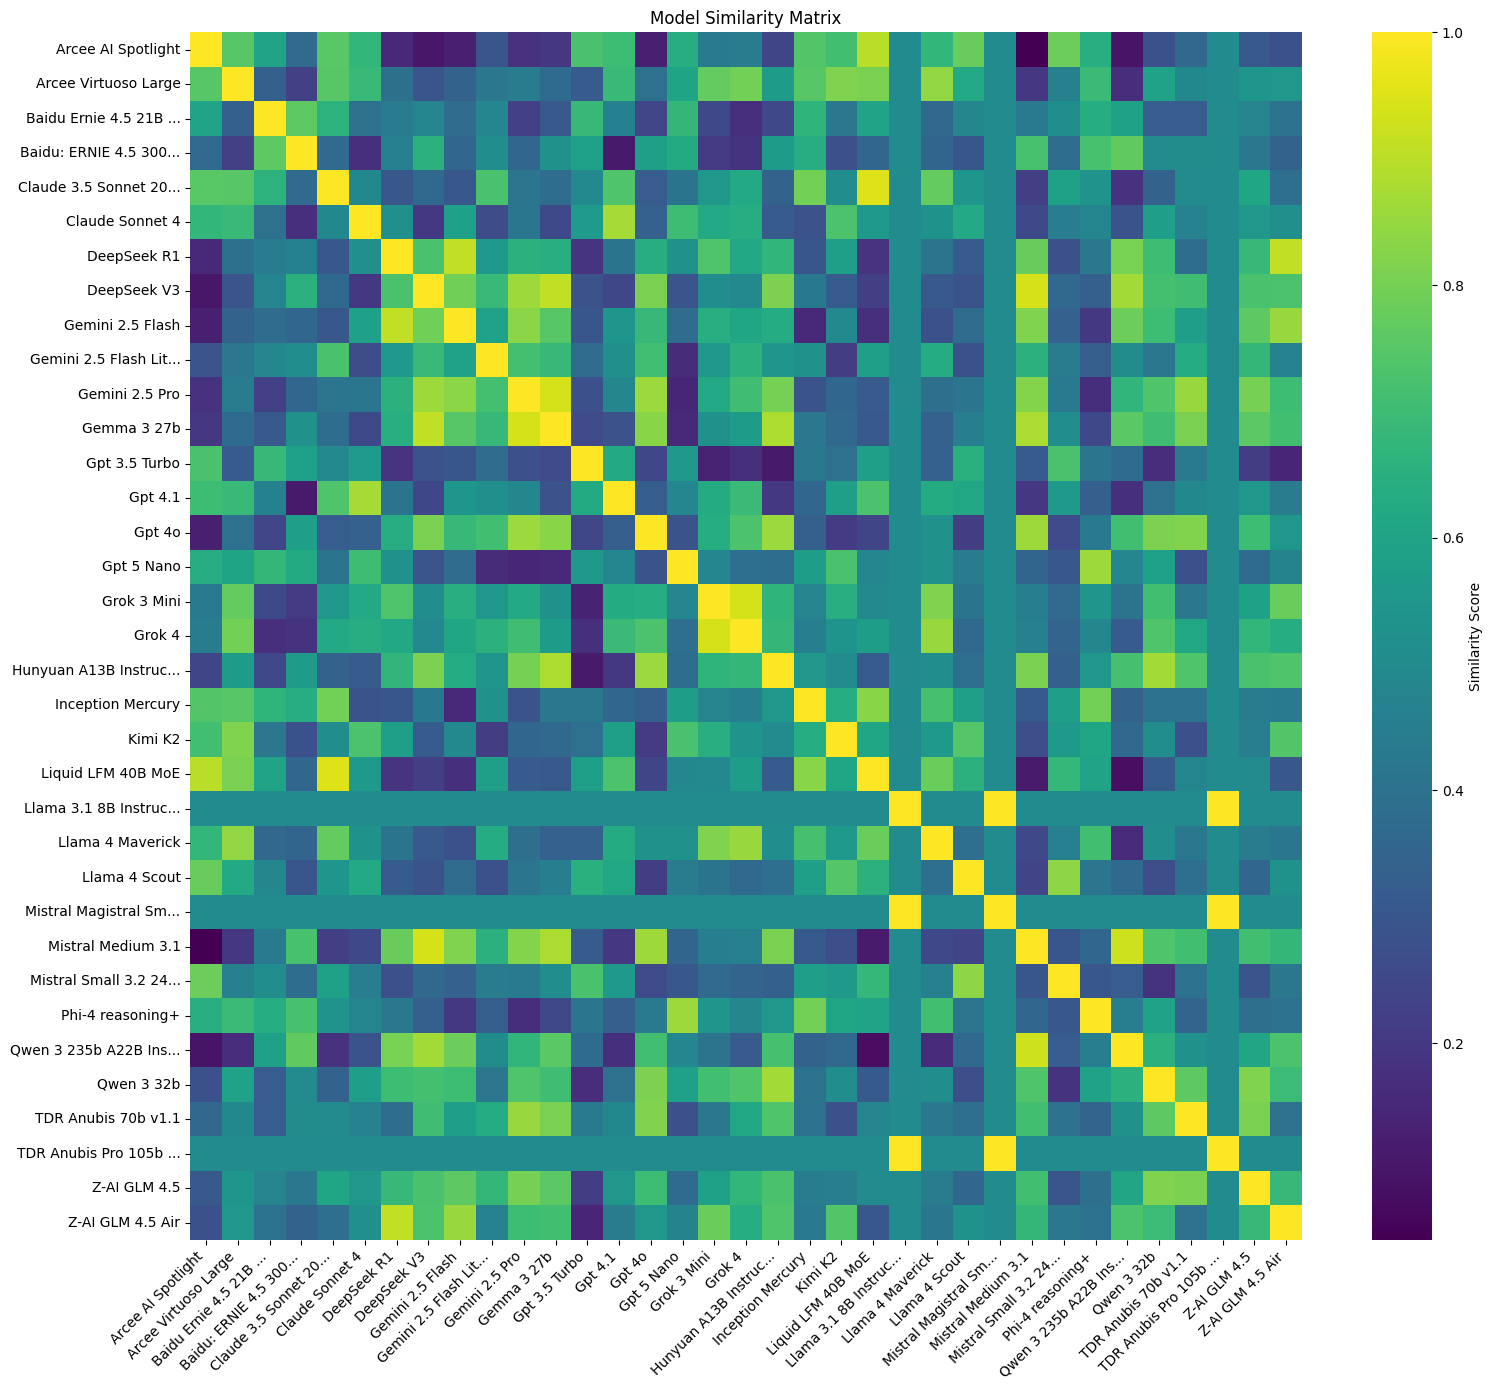

In [11]:
# Similarity matrix heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(similarity_matrix, 
            xticklabels=[name[:20] + '...' if len(name) > 20 else name for name in model_names],
            yticklabels=[name[:20] + '...' if len(name) > 20 else name for name in model_names],
            cmap='viridis', 
            cbar_kws={'label': 'Similarity Score'})
plt.title('Model Similarity Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# Find most and least similar model pairs
n_models = len(model_names)
similarity_pairs = []

for i in range(n_models):
    for j in range(i+1, n_models):
        similarity_pairs.append({
            'model1': model_names[i],
            'model2': model_names[j],
            'similarity': similarity_matrix[i, j]
        })

similarity_df = pd.DataFrame(similarity_pairs)

print("=== MOST SIMILAR MODEL PAIRS ===")
most_similar = similarity_df.nlargest(10, 'similarity')
for _, row in most_similar.iterrows():
    print(f"{row['model1']} <-> {row['model2']}: {row['similarity']:.4f}")

print("\n=== LEAST SIMILAR MODEL PAIRS ===")
least_similar = similarity_df.nsmallest(10, 'similarity')
for _, row in least_similar.iterrows():
    print(f"{row['model1']} <-> {row['model2']}: {row['similarity']:.4f}")

=== MOST SIMILAR MODEL PAIRS ===
Llama 3.1 8B Instruct <-> TDR Anubis Pro 105b v1: 1.0000
Mistral Magistral Small 2506 <-> TDR Anubis Pro 105b v1: 1.0000
Llama 3.1 8B Instruct <-> Mistral Magistral Small 2506: 1.0000
Claude 3.5 Sonnet 20240620 <-> Liquid LFM 40B MoE: 0.9502
Grok 3 Mini <-> Grok 4: 0.9401
Gemini 2.5 Pro <-> Gemma 3 27b: 0.9383
DeepSeek V3 <-> Mistral Medium 3.1: 0.9379
Mistral Medium 3.1 <-> Qwen 3 235b A22B Instruct: 0.9270
DeepSeek R1 <-> Z-AI GLM 4.5 Air: 0.9103
DeepSeek V3 <-> Gemma 3 27b: 0.9094

=== LEAST SIMILAR MODEL PAIRS ===
Arcee AI Spotlight <-> Mistral Medium 3.1: 0.0443
Liquid LFM 40B MoE <-> Qwen 3 235b A22B Instruct: 0.0801
Arcee AI Spotlight <-> Qwen 3 235b A22B Instruct: 0.0958
Arcee AI Spotlight <-> DeepSeek V3: 0.1019
Baidu: ERNIE 4.5 300B A47B <-> Gpt 4.1: 0.1081
Gpt 3.5 Turbo <-> Hunyuan A13B Instruct: 0.1086
Liquid LFM 40B MoE <-> Mistral Medium 3.1: 0.1147
Arcee AI Spotlight <-> Gpt 4o: 0.1273
Arcee AI Spotlight <-> Gemini 2.5 Flash: 0.1279
Gpt 3

## 7. SSS vs Sycophancy Comparison

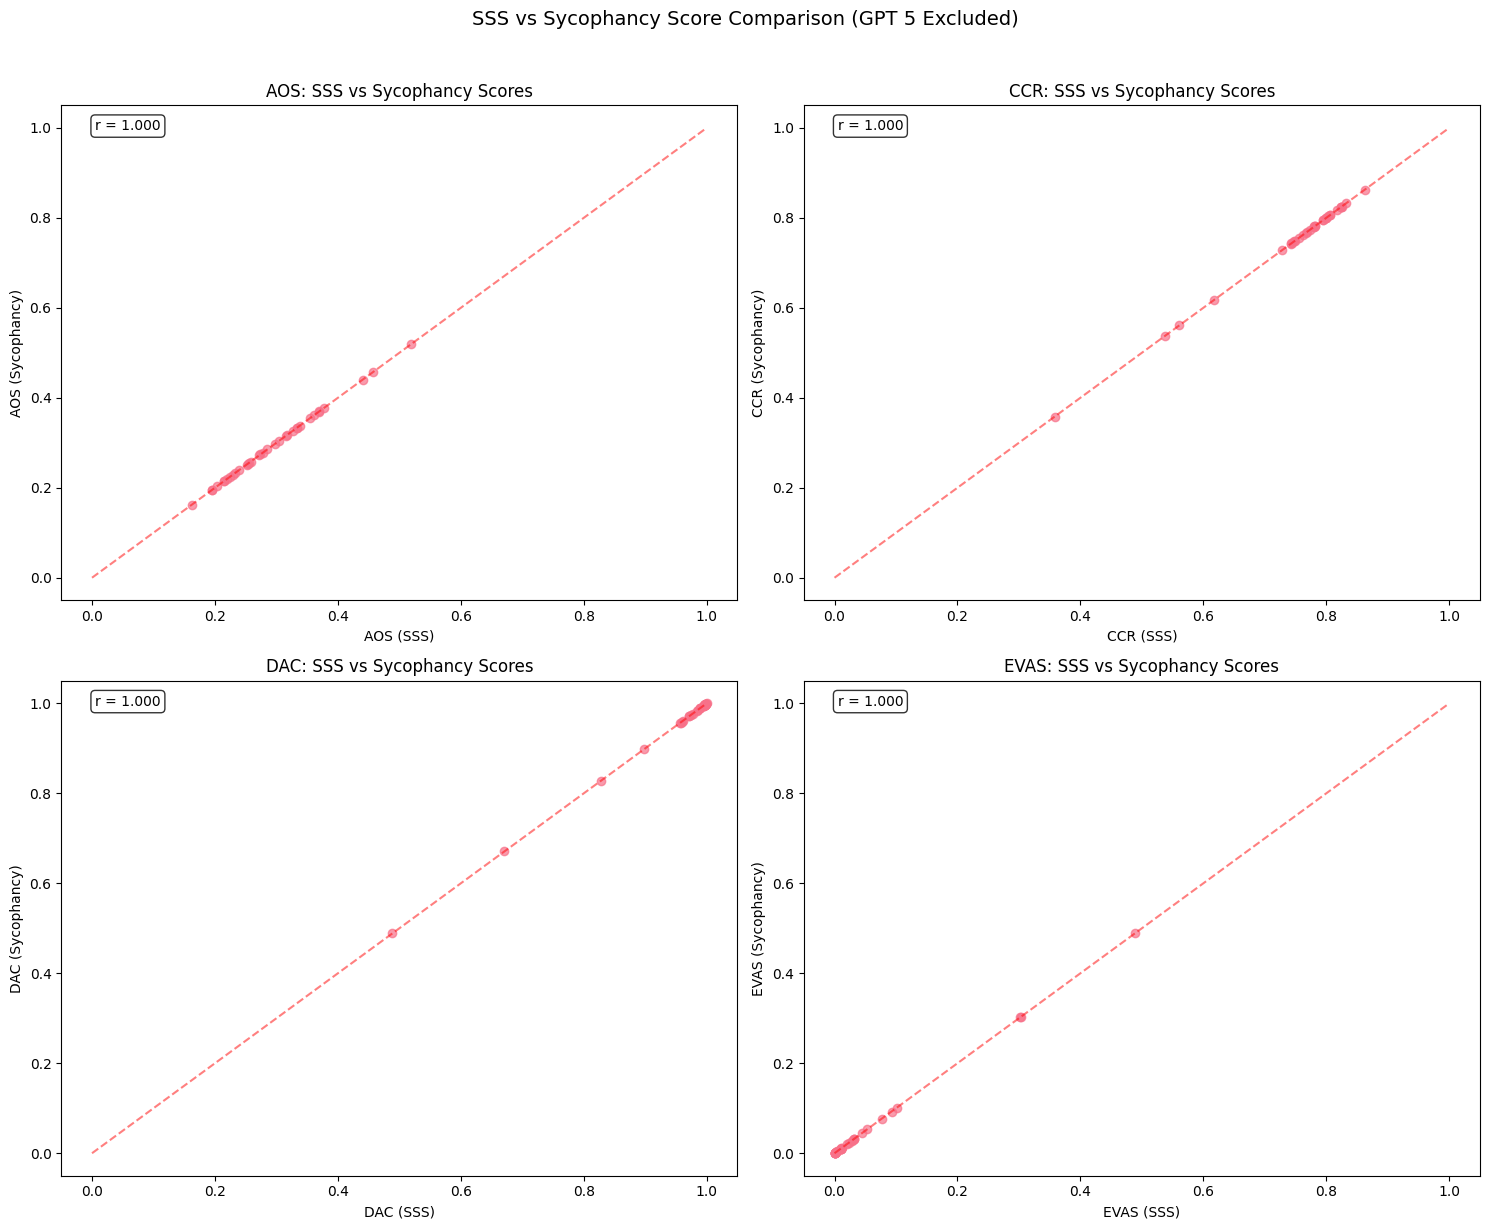

In [13]:
# Merge SSS and Sycophancy data
merged_df = pd.merge(sycophancy_df, sss_df, on='model', suffixes=('_syc', '_sss'))

# Compare key metrics between SSS and Sycophancy
comparison_metrics = ['AOS', 'CCR', 'DAC', 'EVAS']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, metric in enumerate(comparison_metrics):
    syc_col = f'{metric}_syc'
    sss_col = f'{metric}_sss'
    
    axes[i].scatter(merged_df[sss_col], merged_df[syc_col], alpha=0.7)
    axes[i].plot([0, 1], [0, 1], 'r--', alpha=0.5)  # diagonal line
    axes[i].set_xlabel(f'{metric} (SSS)')
    axes[i].set_ylabel(f'{metric} (Sycophancy)')
    axes[i].set_title(f'{metric}: SSS vs Sycophancy Scores')
    
    # Calculate correlation
    corr = merged_df[sss_col].corr(merged_df[syc_col])
    axes[i].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[i].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('SSS vs Sycophancy Score Comparison (GPT 5 Excluded)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 8. Network Analysis

## 8. Key Findings and Insights

In [14]:
# Generate key insights
print("=== KEY FINDINGS (GPT 5 EXCLUDED) ===")
print(f"1. Total models analyzed: {len(model_names)} (originally 36, excluded GPT 5)")
print(f"2. Mean Sycophancy Index: {sycophancy_df['SI'].mean():.4f} (±{sycophancy_df['SI'].std():.4f})")
print(f"3. Highest SI: {sycophancy_df.loc[sycophancy_df['SI'].idxmax(), 'model']} ({sycophancy_df['SI'].max():.4f})")
print(f"4. Lowest SI: {sycophancy_df.loc[sycophancy_df['SI'].idxmin(), 'model']} ({sycophancy_df['SI'].min():.4f})")

# Strongest correlations with SI
si_correlations = sycophancy_df[metric_cols].corrwith(sycophancy_df['SI']).abs().sort_values(ascending=False)
print(f"\n5. Metrics most correlated with SI:")
for metric, corr in si_correlations.head(5).items():
    print(f"   - {metric}: {corr:.4f}")

# Family insights
family_si_mean = sycophancy_df.groupby('family')['SI'].mean().sort_values(ascending=False)
print(f"\n6. Model families by mean SI:")
for family, si in family_si_mean.items():
    count = sycophancy_df[sycophancy_df['family'] == family].shape[0]
    print(f"   - {family}: {si:.4f} (n={count})")

print(f"\n7. Analysis parameters:")
print(f"   - KNN k: {metadata['knn_k']}")
print(f"   - Leiden resolution: {metadata['leiden_resolution']}")
print(f"   - Bridge threshold: {metadata['bridge_threshold']}")
print(f"   - LLM Judge: {metadata['scoring']['LLM_JUDGE_MODEL']}")
print(f"   - Excluded models: GPT 5 (empty responses due to misconfiguration)")

=== KEY FINDINGS (GPT 5 EXCLUDED) ===
1. Total models analyzed: 35 (originally 36, excluded GPT 5)
2. Mean Sycophancy Index: 0.1728 (±0.0528)
3. Highest SI: TDR Anubis Pro 105b v1 (0.3497)
4. Lowest SI: Phi-4 reasoning+ (0.1147)

5. Metrics most correlated with SI:
   - CCR: 0.8504
   - CAVEAT1: 0.8474
   - DAC: 0.7150
   - RR: 0.6580
   - EVAS: 0.6520

6. Model families by mean SI:
   - Gemini: 0.2033 (n=3)
   - Mistral: 0.1942 (n=3)
   - Grok: 0.1886 (n=2)
   - Other: 0.1779 (n=12)
   - Llama: 0.1662 (n=3)
   - DeepSeek: 0.1605 (n=2)
   - Claude: 0.1588 (n=2)
   - GPT: 0.1540 (n=4)
   - Qwen: 0.1537 (n=2)
   - Baidu/ERNIE: 0.1409 (n=2)

7. Analysis parameters:
   - KNN k: 8
   - Leiden resolution: 1.0
   - Bridge threshold: 0.5
   - LLM Judge: qwen/qwen3-235b-a22b-2507
   - Excluded models: GPT 5 (empty responses due to misconfiguration)


## 9. Export Results Summary

In [15]:
# Create summary report
summary_report = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_models': len(model_names),
    'excluded_models': ['Gpt 5'],
    'exclusion_reason': 'Empty responses due to misconfiguration during run',
    'si_statistics': {
        'mean': float(sycophancy_df['SI'].mean()),
        'std': float(sycophancy_df['SI'].std()),
        'min': float(sycophancy_df['SI'].min()),
        'max': float(sycophancy_df['SI'].max())
    },
    'top_performers': sycophancy_df.nlargest(5, 'SI')[['model', 'SI']].to_dict('records'),
    'bottom_performers': sycophancy_df.nsmallest(5, 'SI')[['model', 'SI']].to_dict('records'),
    'family_rankings': family_si_mean.to_dict(),
    'key_correlations': si_correlations.head(5).to_dict()
}

# Save summary
# with open('../results/analysis_summary_filtered.json', 'w') as f:
#     json.dump(summary_report, f, indent=2)

print("Analysis complete! Summary saved to ../results/analysis_summary_filtered.json")
print("\nThis notebook provides a comprehensive analysis of LLM sycophancy across 35 models.")
print("GPT 5 was excluded due to empty responses from misconfiguration during the run.")
print("Key insights include model rankings, family comparisons, and metric correlations.")

Analysis complete! Summary saved to ../results/analysis_summary_filtered.json

This notebook provides a comprehensive analysis of LLM sycophancy across 35 models.
GPT 5 was excluded due to empty responses from misconfiguration during the run.
Key insights include model rankings, family comparisons, and metric correlations.


## Network Analysis

In [93]:
from typing import List, Tuple, Dict, Optional
import networkx as nx
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, to_rgba


def plot_network(
    names: List[str],
    S: np.ndarray,
    pos: Dict[str, Tuple[float, float]],
    G_backbone: nx.Graph,
    node_to_comm: Dict[str, int],
    *,
    Q: float,
    conductance: Dict[int, float],
    participation: Dict[str, float],
    admixtures: Optional[List[Dict]] = None,
    title: str = "Sycophantic Behavioral Network",
    bridge_threshold: float = 0.5,
) -> plt.Figure:
    G = G_backbone.copy()
    # Edge thickness based on similarity
    ew = []
    for u, v in G.edges():
        i, j = names.index(u), names.index(v)
        ew.append(S[i, j])
    if len(ew):
        w_arr = np.array(ew)
        w_lo, w_hi = float(w_arr.min()), float(w_arr.max())
        w_norm = (w_arr - w_lo) / (w_hi - w_lo) if w_hi > w_lo else w_arr * 0 + 1
    else:
        w_norm = np.array([])

    bg, fg, accent = "#0A0E1A", "#E6F1FF", "#64FFDA"
    comm_ids = sorted(set(node_to_comm.values()))
    comm_colors = _palette(len(comm_ids))
    color_map = {nm: comm_colors[node_to_comm.get(nm, 0) % len(comm_colors)] for nm in names}
    node_colors = [color_map[nm] for nm in G.nodes()]
    node_sizes = [950 + 380 * G.degree[nm] for nm in G.nodes()]

    P = participation or {}
    bridges = [nm for nm in G.nodes() if P.get(nm, 0.0) >= bridge_threshold]

    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(25, 18), facecolor=bg)
    ax.set_facecolor(bg)

    # Vignette
    r = 200
    yy, xx = np.mgrid[-r:r, -r:r]
    dist = np.sqrt(xx**2 + yy**2)
    vign = np.clip((dist / dist.max()) ** 1.6, 0, 1)
    ax.imshow(
        vign,
        extent=[-1.2, 1.2, -1.1, 1.1],
        cmap=LinearSegmentedColormap.from_list(
            "vign",
            [(0.0, (10 / 255, 14 / 255, 26 / 255, 0.0)), (1.0, (10 / 255, 14 / 255, 26 / 255, 1.0))],
        ),
        interpolation="bicubic",
    )

    # Backbone edges
    if G.number_of_edges() > 0:
        segments, widths, alphas = [], [], []
        idx = 0
        for u, v in G.edges():
            x0, y0 = pos[u]
            x1, y1 = pos[v]
            segments.append([(x0, y0), (x1, y1)])
            s = float(w_norm[idx]) if len(w_norm) else 0.7
            widths.append(1.0 + 4.0 * s)
            alphas.append(0.25 + 0.55 * s)
            idx += 1
        edge_colors = [(100 / 255.0, 255 / 255.0, 218 / 255.0, float(a)) for a in alphas]
        lc = LineCollection(segments, colors=edge_colors, linewidths=widths, capstyle="round", joinstyle="round")
        lc.set_zorder(1)
        ax.add_collection(lc)

    # Optional admixture edges 
    if admixtures:
        for e in admixtures:
            c = e["child"]
            for p in e["parents"]:
                x0, y0 = pos[c]
                x1, y1 = pos[p]
                ax.plot(
                    [x0, x1],
                    [y0, y1],
                    linestyle=(0, (4, 6)),
                    color=(100 / 255, 255 / 255, 218 / 255, 0.45),
                    linewidth=2.0,
                    zorder=1.1,
                )

    # Node glow
    glow_sizes = [s * 1.35 for s in node_sizes]
    glow_colors = [to_rgba(c, 0.18) for c in node_colors]
    glow_artist = nx.draw_networkx_nodes(G, pos, node_color=glow_colors, node_size=glow_sizes, linewidths=0, ax=ax)
    glow_artist.set_zorder(2)

    # Node core
    node_border = (1.0, 1.0, 1.0, 0.95)
    core_artist = nx.draw_networkx_nodes(
        G, pos, node_color=node_colors, node_size=node_sizes, linewidths=2.5, edgecolors=[node_border] * G.number_of_nodes(), ax=ax
    )
    core_artist.set_zorder(3)
    try:
        core_artist.set_path_effects([pe.Stroke(linewidth=11, foreground=(1, 1, 1, 0.04)), pe.Normal()])
    except Exception:
        pass

    # Highlight bridges
    if bridges:
        node_size_map = dict(zip(list(G.nodes()), node_sizes))
        ring_sizes = [node_size_map[nm] * 1.12 for nm in bridges]
        ring = nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=bridges,
            node_color="none",
            node_size=ring_sizes,
            linewidths=2.2,
            edgecolors=accent,
            ax=ax,
        )
        ring.set_zorder(3.5)

    # Labels
    labels = {n: n for n in G.nodes()}
    txt = nx.draw_networkx_labels(G, pos, labels=labels, font_size=13, font_weight="bold", font_color=fg, ax=ax)
    for t in txt.values():
        t.set_zorder(4)
        t.set_path_effects([pe.withStroke(linewidth=4, foreground=(0, 0, 0, 0.45)), pe.Normal()])

    # Title
    ax.text(0.5, 0.98, title, transform=ax.transAxes, ha="center", va="top", fontsize=22, fontweight="bold", color=accent)

    # Stats
    cond_vals = list(conductance.values()) if conductance else []
    cond_med = np.median(cond_vals) if cond_vals else 0.0
    bridge_count = len(bridges)
    stats = (
        f"Nodes: {G.number_of_nodes()}  "
        f"Backbone edges: {G.number_of_edges()}  \n"
        f"Communities: {len(set(node_to_comm.values()))} "
        f"(Leiden on k-NN)\n"
        f"Modularity Q: {Q:.3f}  Median conductance: {cond_med:.3f}  \n"
        f"Bridges (P ≥ {bridge_threshold:.2f}): {bridge_count}"
    )
    ax.text(
        0.98,
        0.02,
        stats,
        transform=ax.transAxes,
        ha="right",
        va="bottom",
        fontsize=12.5,
        color=fg,
        bbox=dict(
            boxstyle="round,pad=0.55,rounding_size=0.6",
            facecolor="#151B2A",
            alpha=0.92,
            edgecolor=accent,
            linewidth=1.6,
        ),
    )

    # Legend
    legend_handles = []
    for idx in range(len(comm_ids)):
        h = plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=comm_colors[idx % len(comm_colors)], markersize=10, linestyle="")
        legend_handles.append(h)
    if legend_handles:
        leg = ax.legend(
            legend_handles,
            [f"Community {i+1}" for i in range(len(legend_handles))],
            loc="upper right",
            frameon=True,
            fancybox=True,
            framealpha=0.9,
            facecolor="#151B2A",
            edgecolor=accent,
            fontsize=11.5,
            title="Communities",
        )
        leg.get_title().set_color(accent)
        leg.get_title().set_fontweight("bold")
        for text in leg.get_texts():
            text.set_color(fg)

    ax.axis("off")
    plt.tight_layout()
    return fig

def _palette(n: int) -> List[str]:
    base = [
        "#64FFDA",
        "#7C4DFF",
        "#FF6B6B",
        "#FFCA28",
        "#29B6F6",
        "#66BB6A",
        "#F06292",
        "#26A69A",
        "#AB47BC",
        "#FFA726",
    ]
    return [base[i % len(base)] for i in range(n)]

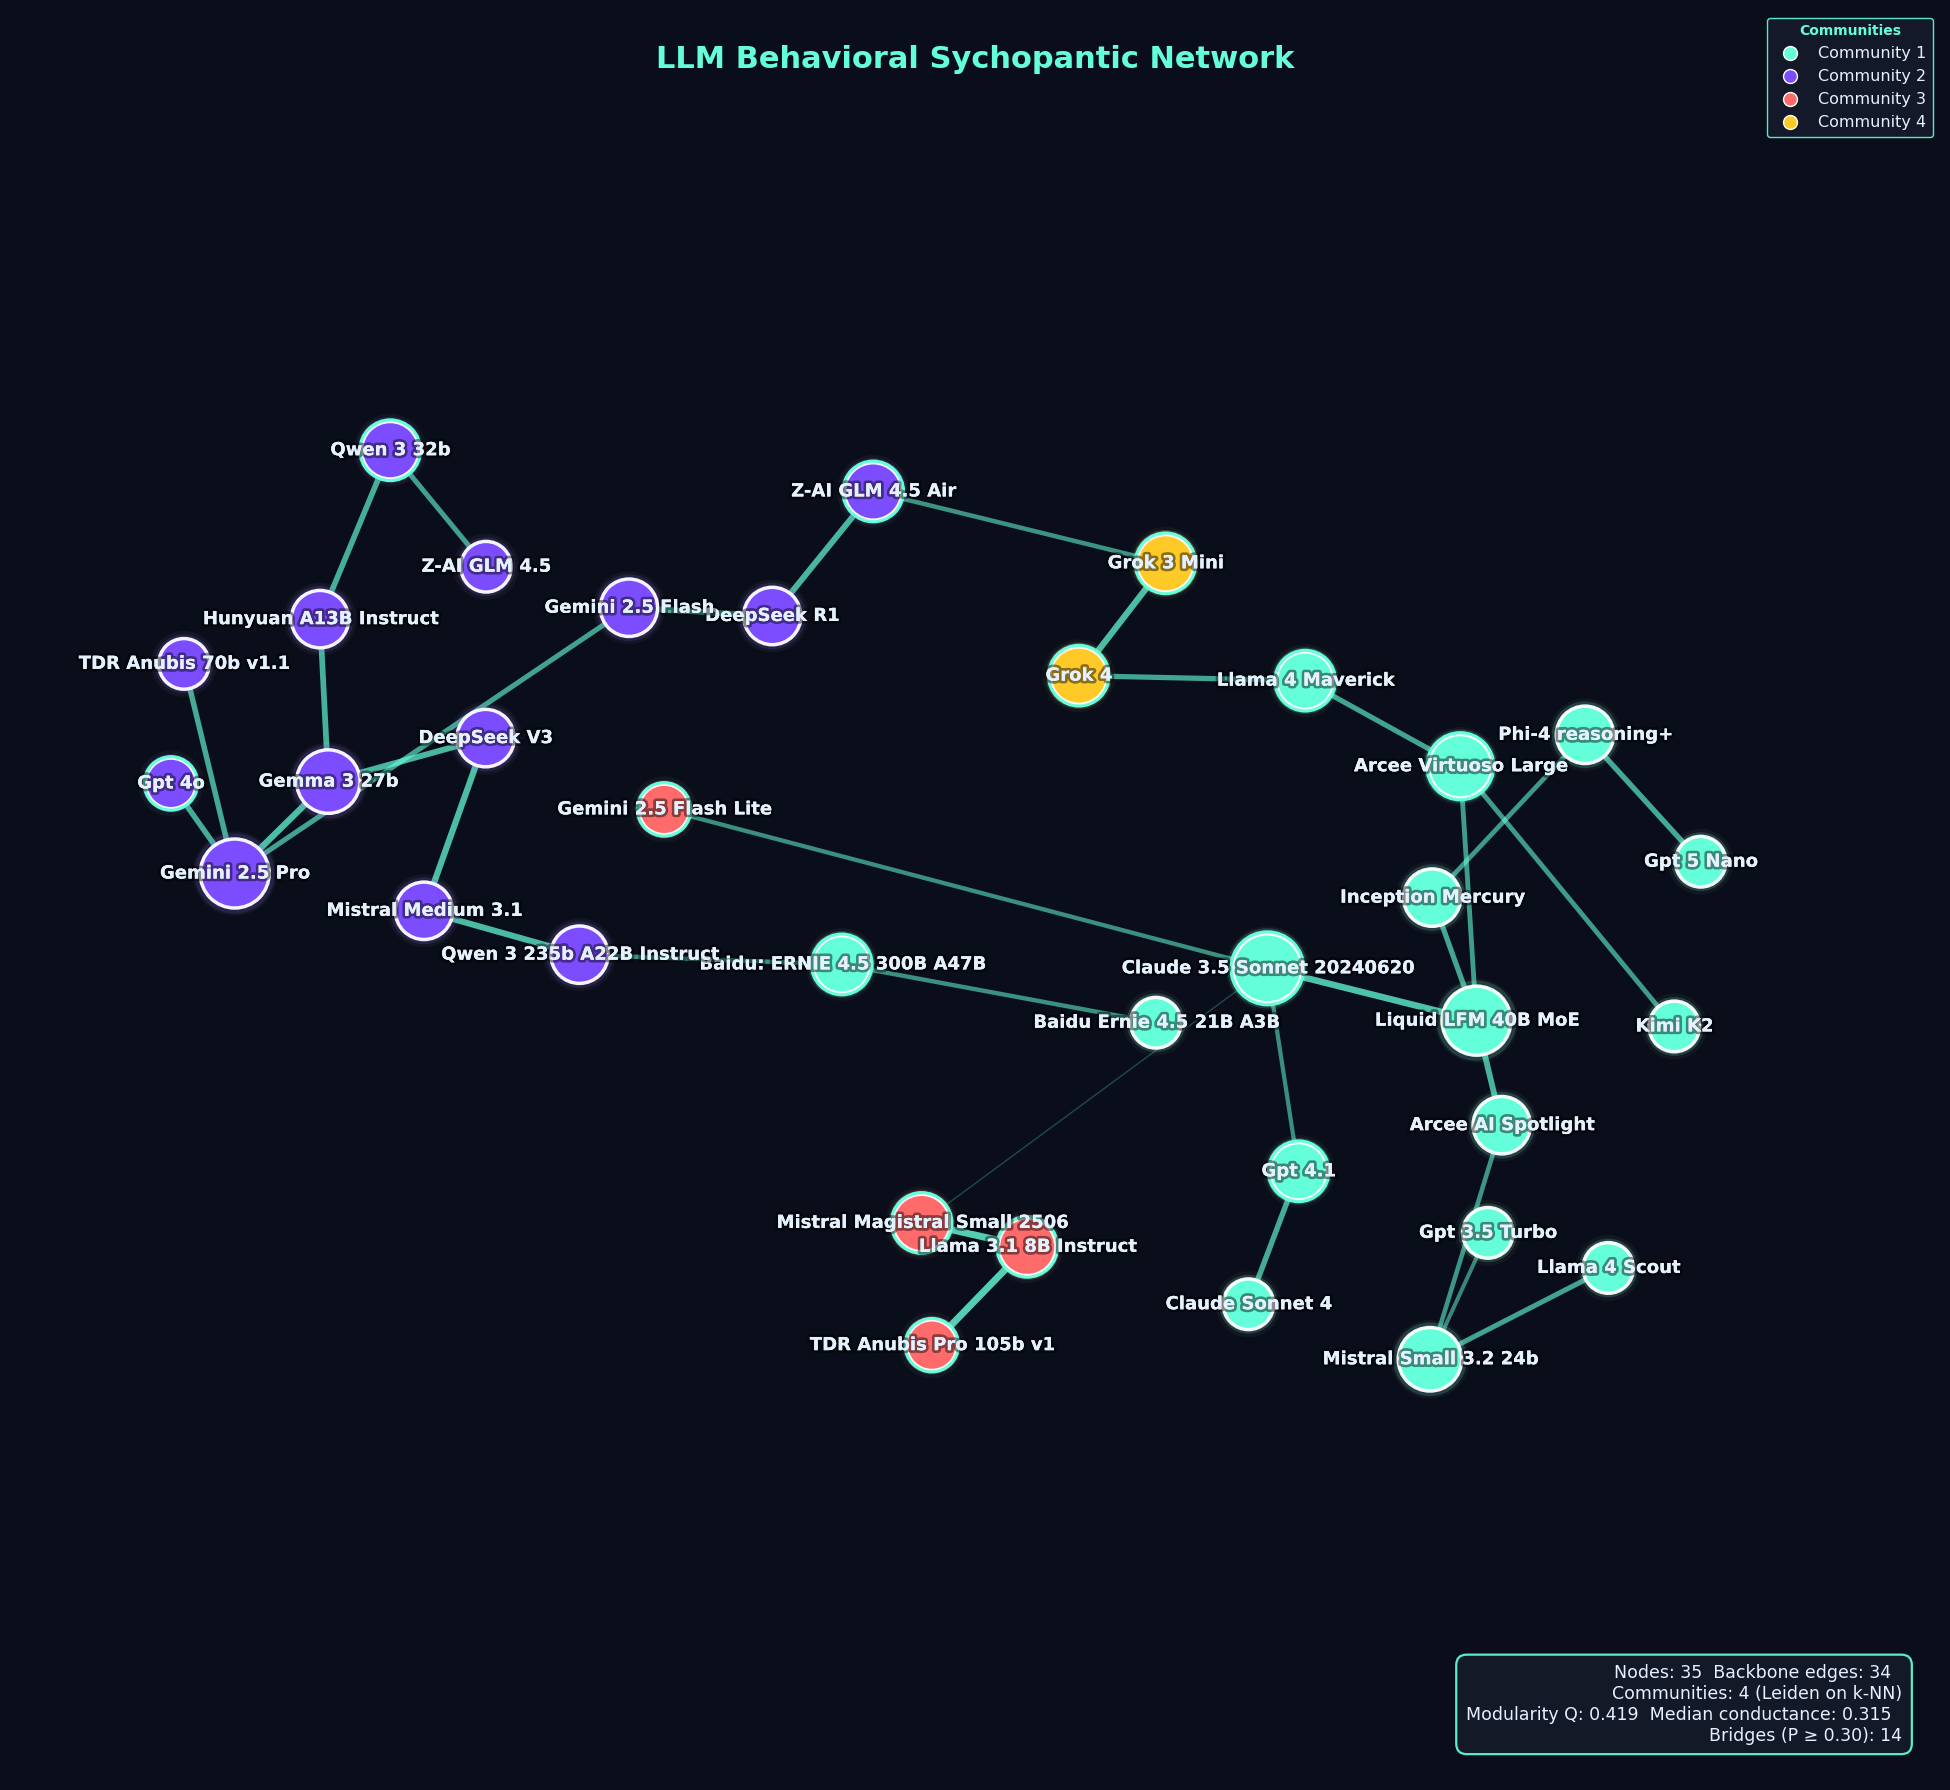

In [94]:
import sys
sys.path.append('../')
from sycophancy_analysis.analysis import (
    similarity_from_vectors, _symmetrize_clip, _dist_from_sim,
    umap_layout, mst_backbone, knn_graph_from_similarity,
    detect_communities, weighted_modularity,
    conductance_per_community, participation_coefficient
)
# from sycophancy_analysis.visualization import plot_network

# 1. Use SSS vectors to compute similarity (like pipeline)
names, S = similarity_from_vectors(sss_vectors)
S = _symmetrize_clip(S)
D = _dist_from_sim(S)

# 2. UMAP layout (like pipeline)
pos = umap_layout(names, D)

# 3. MST backbone for visualization
G_backbone = mst_backbone(names, D)

# 4. KNN graph for community detection (like pipeline)
G_comm = knn_graph_from_similarity(names, S, k=6)
node_to_comm, method_used = detect_communities(
    G_comm, method="leiden", resolution=1.0, seed=42
)

# 5. Compute metrics
Q = weighted_modularity(G_comm, node_to_comm)
conductance = conductance_per_community(G_comm, node_to_comm)
participation = participation_coefficient(G_comm, node_to_comm)

# 6. Plot (now matches pipeline exactly)
fig = plot_network(
    names, S, pos, G_backbone, node_to_comm,
    Q=Q, conductance=conductance, participation=participation,
    title="LLM Behavioral Sychopantic Network",
    bridge_threshold=0.3
)
plt.show()

--- Average Behavioral Profile by Community ---
              SI    AOS    CCR    HVS   FLAT   SAFE     AE
community                                                 
0          0.142  0.245  0.783  0.010  0.004  0.084  0.068
1          0.181  0.355  0.781  0.075  0.010  0.067  0.065
2          0.259  0.228  0.546  0.013  0.007  0.059  0.015
3          0.189  0.413  0.798  0.060  0.022  0.098  0.102


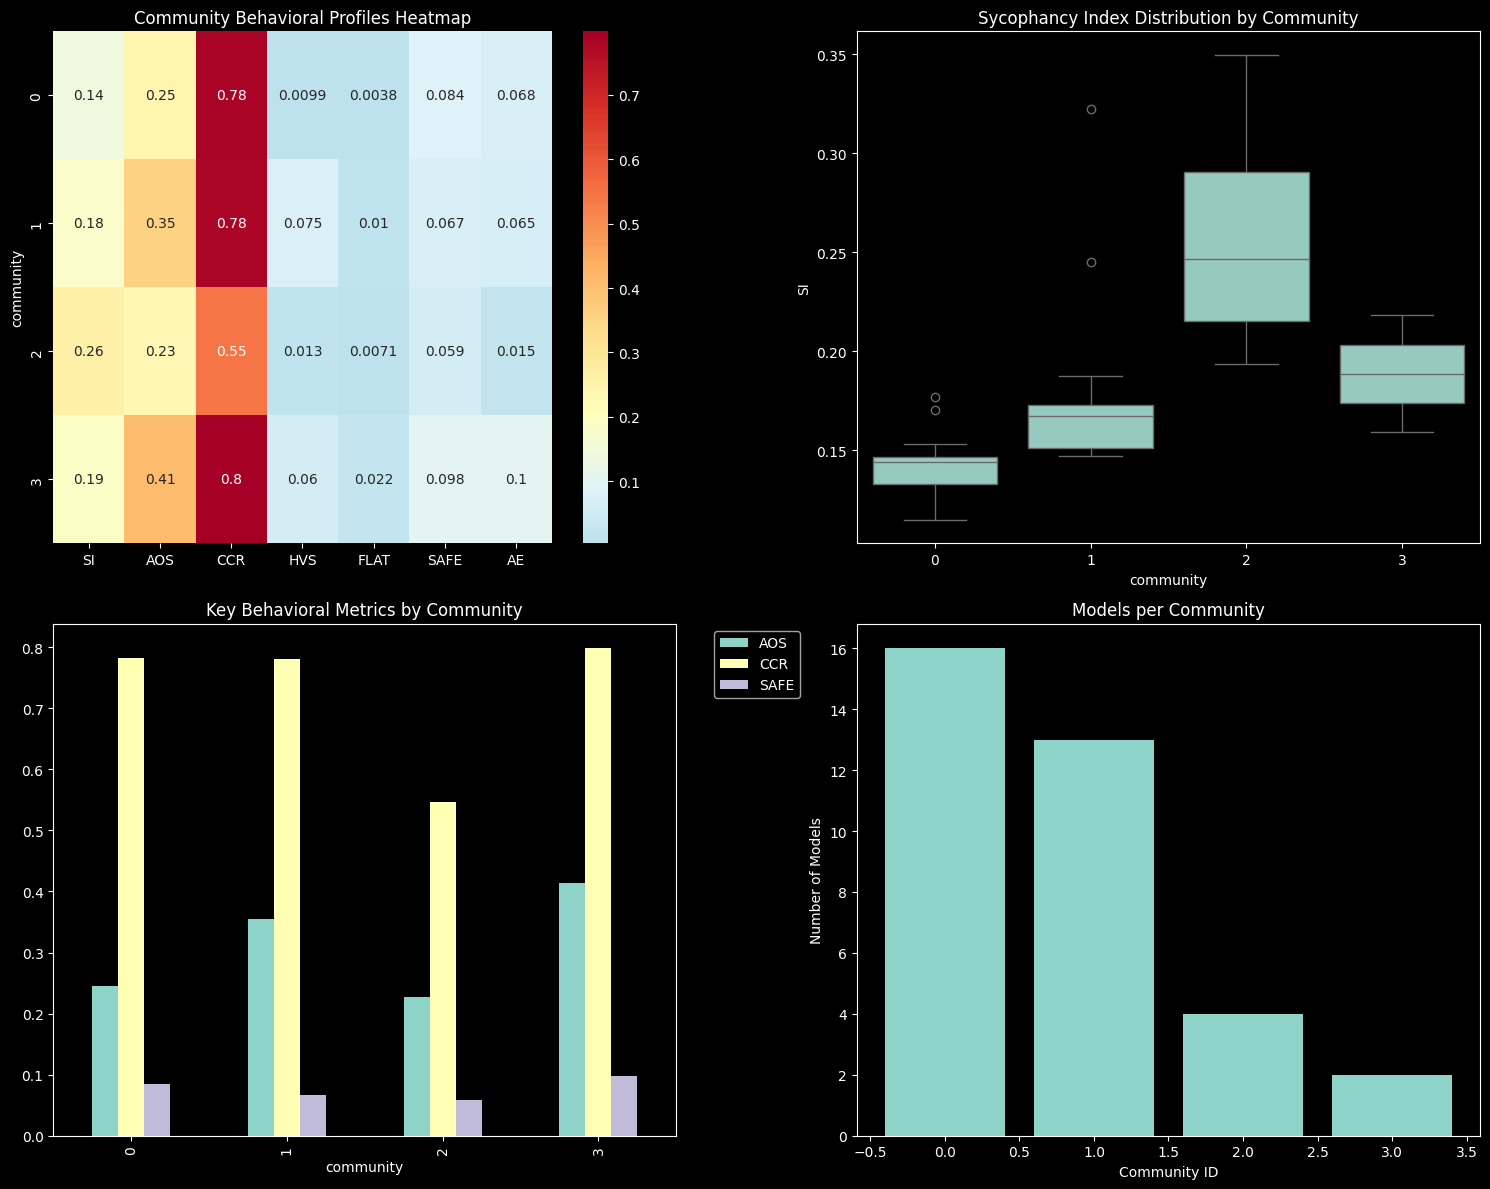


--- Models by Community ---
Community 0 (16 models):
  - Gpt 4.1 (SI: 0.177)
  - Claude 3.5 Sonnet 20240620 (SI: 0.170)
  - Gpt 3.5 Turbo (SI: 0.153)
  - Claude Sonnet 4 (SI: 0.147)
  - Llama 4 Maverick (SI: 0.147)
  - Liquid LFM 40B MoE (SI: 0.146)
  - Arcee Virtuoso Large (SI: 0.145)
  - Mistral Small 3.2 24b (SI: 0.145)
  - Baidu Ernie 4.5 21B A3B (SI: 0.143)
  - Baidu: ERNIE 4.5 300B A47B (SI: 0.139)
  - Inception Mercury (SI: 0.134)
  - Arcee AI Spotlight (SI: 0.133)
  - Kimi K2 (SI: 0.131)
  - Llama 4 Scout (SI: 0.130)
  - Gpt 5 Nano (SI: 0.124)
  - Phi-4 reasoning+ (SI: 0.115)

Community 1 (13 models):
  - TDR Anubis 70b v1.1 (SI: 0.322)
  - Gemini 2.5 Pro (SI: 0.245)
  - Gemma 3 27b (SI: 0.187)
  - Z-AI GLM 4.5 (SI: 0.173)
  - DeepSeek V3 (SI: 0.172)
  - Gemini 2.5 Flash (SI: 0.171)
  - Mistral Medium 3.1 (SI: 0.167)
  - Gpt 4o (SI: 0.162)
  - Qwen 3 32b (SI: 0.157)
  - Hunyuan A13B Instruct (SI: 0.151)
  - Qwen 3 235b A22B Instruct (SI: 0.150)
  - DeepSeek R1 (SI: 0.149)
  - 

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use your existing sycophancy_df and node_to_comm from the network analysis
si_table = sycophancy_df.copy()  # Your sycophancy scores dataframe
# node_to_comm already exists from your network analysis

# Add the community ID to your scores table
si_table['community'] = si_table['model'].map(node_to_comm)

# Define the key behavioral metrics you want to analyze
behavioral_metrics = ['SI', 'AOS', 'CCR', 'HVS', 'FLAT', 'SAFE', 'AE']

# Calculate the average profile for each community
community_profiles = si_table.groupby('community')[behavioral_metrics].mean()

# Display the table - this is your core quantitative result!
print("--- Average Behavioral Profile by Community ---")
print(community_profiles.round(3))

# Enhanced visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Heatmap of community profiles
sns.heatmap(community_profiles, annot=True, cmap='RdYlBu_r', 
            center=community_profiles.mean().mean(), ax=axes[0,0])
axes[0,0].set_title('Community Behavioral Profiles Heatmap')

# 2. SI by community boxplot
sns.boxplot(data=si_table, x='community', y='SI', ax=axes[0,1])
axes[0,1].set_title('Sycophancy Index Distribution by Community')

# 3. Key metrics comparison
community_profiles[['AOS', 'CCR', 'SAFE']].plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Key Behavioral Metrics by Community')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Community sizes
community_sizes = si_table['community'].value_counts().sort_index()
axes[1,1].bar(community_sizes.index, community_sizes.values)
axes[1,1].set_title('Models per Community')
axes[1,1].set_xlabel('Community ID')
axes[1,1].set_ylabel('Number of Models')

plt.tight_layout()
plt.show()

# Show models in each community
print("\n--- Models by Community ---")
for comm_id in sorted(si_table['community'].unique()):
    models_in_comm = si_table[si_table['community'] == comm_id]['model'].tolist()
    print(f"Community {comm_id} ({len(models_in_comm)} models):")
    for model in models_in_comm:
        si_score = si_table[si_table['model'] == model]['SI'].iloc[0]
        print(f"  - {model} (SI: {si_score:.3f})")
    print()

In [28]:
# Test different resolution values
for resolution in [0.5, 0.8, 1.0, 1.2, 1.5, 2.0]:
    node_to_comm, _ = detect_communities(G_comm, method="leiden", resolution=resolution)
    Q = weighted_modularity(G_comm, node_to_comm)
    print(f"Resolution {resolution}: Q = {Q:.3f}")

Resolution 0.5: Q = 0.406
Resolution 0.8: Q = 0.406
Resolution 1.0: Q = 0.419
Resolution 1.2: Q = 0.406
Resolution 1.5: Q = 0.390
Resolution 2.0: Q = 0.383


In [30]:
# Test symmetrization modes
for sym_mode in ["max", "mean"]:
    G_comm = knn_graph_from_similarity(names, S, k=6, sym_mode=sym_mode)
    node_to_comm, _ = detect_communities(G_comm, method="leiden", resolution=1.0)
    Q = weighted_modularity(G_comm, node_to_comm)
    print(f"sym_mode={sym_mode}: Q = {Q:.3f}")

sym_mode=max: Q = 0.419
sym_mode=mean: Q = 0.419


In [31]:
import itertools
import pandas as pd

# Grid search for optimal parameters
results = []
k_values = [4, 6, 8, 10, 12]
resolution_values = [0.5, 0.8, 1.0, 1.2, 1.5]
sym_modes = ["max", "mean"]

for k, resolution, sym_mode in itertools.product(k_values, resolution_values, sym_modes):
    G_comm = knn_graph_from_similarity(names, S, k=k, sym_mode=sym_mode)
    node_to_comm, _ = detect_communities(G_comm, method="leiden", resolution=resolution, seed=42)
    Q = weighted_modularity(G_comm, node_to_comm)
    
    # Calculate additional metrics
    cond = conductance_per_community(G_comm, node_to_comm)
    avg_conductance = sum(cond.values()) / len(cond) if cond else 0
    n_communities = len(set(node_to_comm.values()))
    
    results.append({
        'k': k,
        'resolution': resolution,
        'sym_mode': sym_mode,
        'modularity_Q': Q,
        'n_communities': n_communities,
        'avg_conductance': avg_conductance
    })

# Find best parameters
results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['modularity_Q'].idxmax()]

print("=== OPTIMIZATION RESULTS ===")
print(f"Best Modularity Q: {best_params['modularity_Q']:.3f}")
print(f"Best Parameters:")
print(f"  - k: {best_params['k']}")
print(f"  - resolution: {best_params['resolution']}")
print(f"  - sym_mode: {best_params['sym_mode']}")
print(f"  - Communities: {best_params['n_communities']}")
print(f"  - Avg Conductance: {best_params['avg_conductance']:.3f}")

# Show top 5 configurations
print("\n=== TOP 5 CONFIGURATIONS ===")
top_5 = results_df.nlargest(5, 'modularity_Q')
print(top_5[['k', 'resolution', 'sym_mode', 'modularity_Q', 'n_communities']].to_string(index=False))

=== OPTIMIZATION RESULTS ===
Best Modularity Q: 0.515
Best Parameters:
  - k: 4
  - resolution: 1.0
  - sym_mode: max
  - Communities: 5
  - Avg Conductance: 0.271

=== TOP 5 CONFIGURATIONS ===
 k  resolution sym_mode  modularity_Q  n_communities
 4         1.0      max      0.515413              5
 4         1.0     mean      0.515413              5
 4         1.2      max      0.515413              5
 4         1.2     mean      0.515413              5
 4         1.5      max      0.515413              5


## Admixture Optimization

In [41]:
# Find optimal bridge threshold based on network structure
def analyze_bridge_threshold(participation, thresholds):
    results = []
    for threshold in thresholds:
        bridges = [nm for nm in participation.keys() if participation[nm] >= threshold]
        n_bridges = len(bridges)
        
        # Calculate bridge quality metrics
        bridge_p_values = [participation[nm] for nm in bridges]
        avg_bridge_p = np.mean(bridge_p_values) if bridge_p_values else 0
        
        results.append({
            'threshold': threshold,
            'n_bridges': n_bridges,
            'avg_participation': avg_bridge_p,
            'bridges': bridges
        })
    
    return results

# Test thresholds
thresholds = np.arange(0.2, 0.8, 0.05)
bridge_analysis = analyze_bridge_threshold(participation, thresholds)

print("Bridge threshold analysis:")
for result in bridge_analysis:
    print(f"Threshold {result['threshold']:.2f}: {result['n_bridges']} bridges, "
          f"avg P = {result['avg_participation']:.3f}")

Bridge threshold analysis:
Threshold 0.20: 28 bridges, avg P = 0.437
Threshold 0.25: 28 bridges, avg P = 0.437
Threshold 0.30: 25 bridges, avg P = 0.455
Threshold 0.35: 21 bridges, avg P = 0.479
Threshold 0.40: 18 bridges, avg P = 0.500
Threshold 0.45: 12 bridges, avg P = 0.536
Threshold 0.50: 8 bridges, avg P = 0.564
Threshold 0.55: 5 bridges, avg P = 0.594
Threshold 0.60: 3 bridges, avg P = 0.617
Threshold 0.65: 0 bridges, avg P = 0.000
Threshold 0.70: 0 bridges, avg P = 0.000
Threshold 0.75: 0 bridges, avg P = 0.000
Threshold 0.80: 0 bridges, avg P = 0.000


Participation stats:
  Mean: 0.350
  Std: 0.197
  Max: 0.625
  Min: 0.000


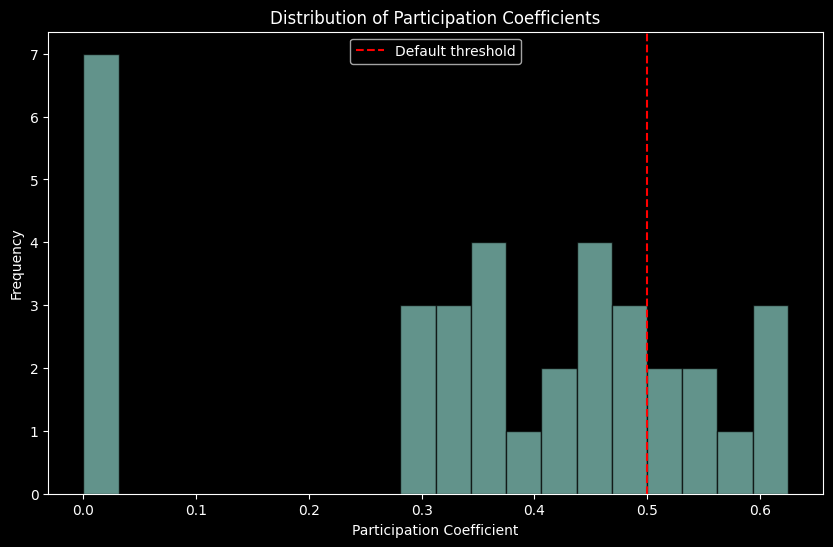


Top 10 bridge candidates:
  Baidu: ERNIE 4.5 300B A47B: 0.625
  Phi-4 reasoning+: 0.622
  Claude 3.5 Sonnet 20240620: 0.605
  Baidu Ernie 4.5 21B A3B: 0.563
  Kimi K2: 0.555
  Gemini 2.5 Flash Lite: 0.533
  Liquid LFM 40B MoE: 0.513
  TDR Anubis Pro 105b v1: 0.500
  DeepSeek V3: 0.500
  Z-AI GLM 4.5 Air: 0.497
Threshold 0.3: 25 bridges
Threshold 0.4: 18 bridges
Threshold 0.5: 8 bridges
Threshold 0.6: 3 bridges
Threshold 0.7: 0 bridges


In [36]:
# Correct way to analyze participation coefficients
import numpy as np
import matplotlib.pyplot as plt

# 1. Get participation coefficients (you should already have this)
participation = participation_coefficient(G_comm, node_to_comm)

# 2. Analyze participation distribution
p_values = list(participation.values())
print(f"Participation stats:")
print(f"  Mean: {np.mean(p_values):.3f}")
print(f"  Std: {np.std(p_values):.3f}")
print(f"  Max: {np.max(p_values):.3f}")
print(f"  Min: {np.min(p_values):.3f}")

# 3. Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(p_values, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Default threshold')
plt.xlabel('Participation Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of Participation Coefficients')
plt.legend()
plt.show()

# 4. Show top bridge candidates
sorted_participation = sorted(participation.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 bridge candidates:")
for model, p_coeff in sorted_participation[:10]:
    print(f"  {model}: {p_coeff:.3f}")

# 5. Test different bridge thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in thresholds:
    bridges = [nm for nm in participation.keys() if participation[nm] >= threshold]
    print(f"Threshold {threshold}: {len(bridges)} bridges")

## Exp

In [73]:
# Cell 1: utilities (hull, small groups, optional subcluster split)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Ellipse, Circle
from matplotlib.collections import PatchCollection
from sklearn.cluster import DBSCAN

def _cross(o, a, b):
    return (a[0]-o[0])*(b[1]-o[1]) - (a[1]-o[1])*(b[0]-o[0])

def convex_hull(points):
    """Correct monotone-chain convex hull, returns CCW vertices (Nx2)."""
    pts = np.asarray(points, dtype=float)
    if len(pts) < 3:
        return pts
    idx = np.lexsort((pts[:,1], pts[:,0]))
    pts = pts[idx]
    lower = []
    for p in pts:
        while len(lower) >= 2 and _cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(tuple(p))
    upper = []
    for p in pts[::-1]:
        while len(upper) >= 2 and _cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(tuple(p))
    hull = np.array(lower[:-1] + upper[:-1])
    return hull

def _data_scale(pos):
    xs = np.array([xy[0] for xy in pos.values()])
    ys = np.array([xy[1] for xy in pos.values()])
    return max(xs.max()-xs.min(), ys.max()-ys.min())

def _subclusters(points, eps, min_samples=2):
    """DBSCAN split for far-apart members; returns list of index arrays."""
    if len(points) <= min_samples:
        return [np.arange(len(points))]
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit(points).labels_
    clusters = []
    for lab in sorted(set(labels)):
        idx = np.where(labels == lab)[0] if lab != -1 else np.where(labels == -1)[0]
        if len(idx):
            clusters.append(idx)
    return clusters

def draw_community_clouds(
    ax, pos, node_to_comm, comm_colors,
    padding=0.06, alpha=0.14, split_far=True, eps_frac=0.08
):
    """
    Draw translucent clouds per community, robust to tiny groups and outliers.
    - padding: expands hull around centroid.
    - split_far: split each community into subclusters with DBSCAN on 2D coords.
    - eps_frac: neighborhood size as a fraction of plot extent for DBSCAN.
    """
    scale = _data_scale(pos)
    eps = eps_frac * scale
    patches, facecolors, edgecolors = [], [], []

    comm_ids = sorted(set(node_to_comm.values()))
    for cid in comm_ids:
        members = [n for n, c in node_to_comm.items() if c == cid]
        pts = np.array([pos[n] for n in members], dtype=float)
        if len(pts) == 0:
            continue

        # optional: split widely separated members into subclouds
        clusters = _subclusters(pts, eps=eps) if split_far else [np.arange(len(pts))]

        for idxs in clusters:
            sub = pts[idxs]
            color = comm_colors[cid]

            if len(sub) >= 3:
                hull = convex_hull(sub)
                # expand around centroid
                centroid = hull.mean(axis=0)
                hull = centroid + (hull - centroid) * (1 + padding)
                patches.append(Polygon(hull, closed=True))
                facecolors.append(color)
                edgecolors.append(color)
            elif len(sub) == 2:
                # oriented ellipse spanning the segment
                p0, p1 = sub[0], sub[1]
                center = (p0 + p1) / 2.0
                vec = p1 - p0
                L = float(np.hypot(*vec))
                angle = np.degrees(np.arctan2(vec[1], vec[0]))
                height = max(0.06 * scale, padding * L * 1.5)  # tweakable
                width = L + height  # give some cap on ends
                patches.append(Ellipse(xy=center, width=width, height=height, angle=angle))
                facecolors.append(color)
                edgecolors.append(color)
            else:  # len == 1
                r = 0.04 * scale  # tweakable
                patches.append(Circle(xy=sub[0], radius=r))
                facecolors.append(color)
                edgecolors.append(color)

    if patches:
        pc = PatchCollection(
            patches, facecolor=facecolors, edgecolor=edgecolors,
            linewidth=1.6, alpha=alpha, zorder=0.9
        )
        ax.add_collection(pc)

def _extent_scale(pos: dict) -> float:
    xs = np.array([p[0] for p in pos.values()])
    ys = np.array([p[1] for p in pos.values()])
    return float(max(xs.max()-xs.min(), ys.max()-ys.min()))

def _anchor_outside(points: np.ndarray, scale: float, side: str, margin_frac: float):
    """
    Compute a label anchor just outside the cluster:
    - side: 'top'|'right'|'bottom'|'left'
    Returns (label_xy, target_xy) where target is the arrow tip on cluster boundary.
    """
    if len(points) == 0:
        return None, None
    hull = _convex_hull(points) if len(points) >= 3 else points
    margin = margin_frac * scale
    if side == 'top':
        y_max = float(np.max(hull[:,1]))
        # choose a stable x near the top
        mask = np.abs(hull[:,1] - y_max) < (0.03 * scale)
        x_sel = hull[mask,0] if np.any(mask) else hull[:,0]
        x_anchor = float(np.median(x_sel))
        label_xy = (x_anchor, y_max + margin)
        target_xy = (x_anchor, y_max)
    elif side == 'bottom':
        y_min = float(np.min(hull[:,1]))
        mask = np.abs(hull[:,1] - y_min) < (0.03 * scale)
        x_sel = hull[mask,0] if np.any(mask) else hull[:,0]
        x_anchor = float(np.median(x_sel))
        label_xy = (x_anchor, y_min - margin)
        target_xy = (x_anchor, y_min)
    elif side == 'right':
        x_max = float(np.max(hull[:,0]))
        mask = np.abs(hull[:,0] - x_max) < (0.03 * scale)
        y_sel = hull[mask,1] if np.any(mask) else hull[:,1]
        y_anchor = float(np.median(y_sel))
        label_xy = (x_max + margin, y_anchor)
        target_xy = (x_max, y_anchor)
    else:  # left
        x_min = float(np.min(hull[:,0]))
        mask = np.abs(hull[:,0] - x_min) < (0.03 * scale)
        y_sel = hull[mask,1] if np.any(mask) else hull[:,1]
        y_anchor = float(np.median(y_sel))
        label_xy = (x_min - margin, y_anchor)
        target_xy = (x_min, y_anchor)
    return label_xy, target_xy

def draw_cloud_labels_outside(
    ax,
    pos: dict,                     # {node: (x,y)}
    node_to_comm: dict,            # {node: cid}
    comm_colors: dict,             # {cid: color}
    cloud_meta: dict,              # {cid: (name, "SI a–b")}
    *,
    side: str = 'top',             # default place above cloud
    margin_frac: float = 0.06,     # how far outside the cloud
    fontsize: int = 12,
    box_face: str = "#151B2A",
    text_color: str = "#E6F1FF"
):
    scale = _extent_scale(pos)
    for cid, (name, si_range) in cloud_meta.items():
        members = [n for n, c in node_to_comm.items() if c == cid]
        if not members:
            continue
        pts = np.array([pos[n] for n in members], dtype=float)
        label_xy, target_xy = _anchor_outside(pts, scale, side, margin_frac)
        if label_xy is None:
            continue
        edge_col = comm_colors.get(cid, (0.9,0.9,0.9,1.0))
        text = f"{name}\n{si_range} (n={len(members)})"
        t = ax.annotate(
            text,
            xy=target_xy, xycoords='data',
            xytext=label_xy, textcoords='data',
            ha='center', va='center',
            fontsize=fontsize, fontweight='bold', color=text_color,
            bbox=dict(
                boxstyle="round,pad=0.55,rounding_size=0.6",
                facecolor=box_face, alpha=0.92,
                edgecolor=edge_col, linewidth=1.6,
            ),
            arrowprops=dict(
                arrowstyle="-|>", color=edge_col, lw=1.6,
                shrinkA=6, shrinkB=6, connectionstyle="arc3,rad=0.12",
                alpha=0.9
            ),
            zorder=4.1
        )
        t.set_path_effects([pe.withStroke(linewidth=4, foreground=(0,0,0,0.45)), pe.Normal()])

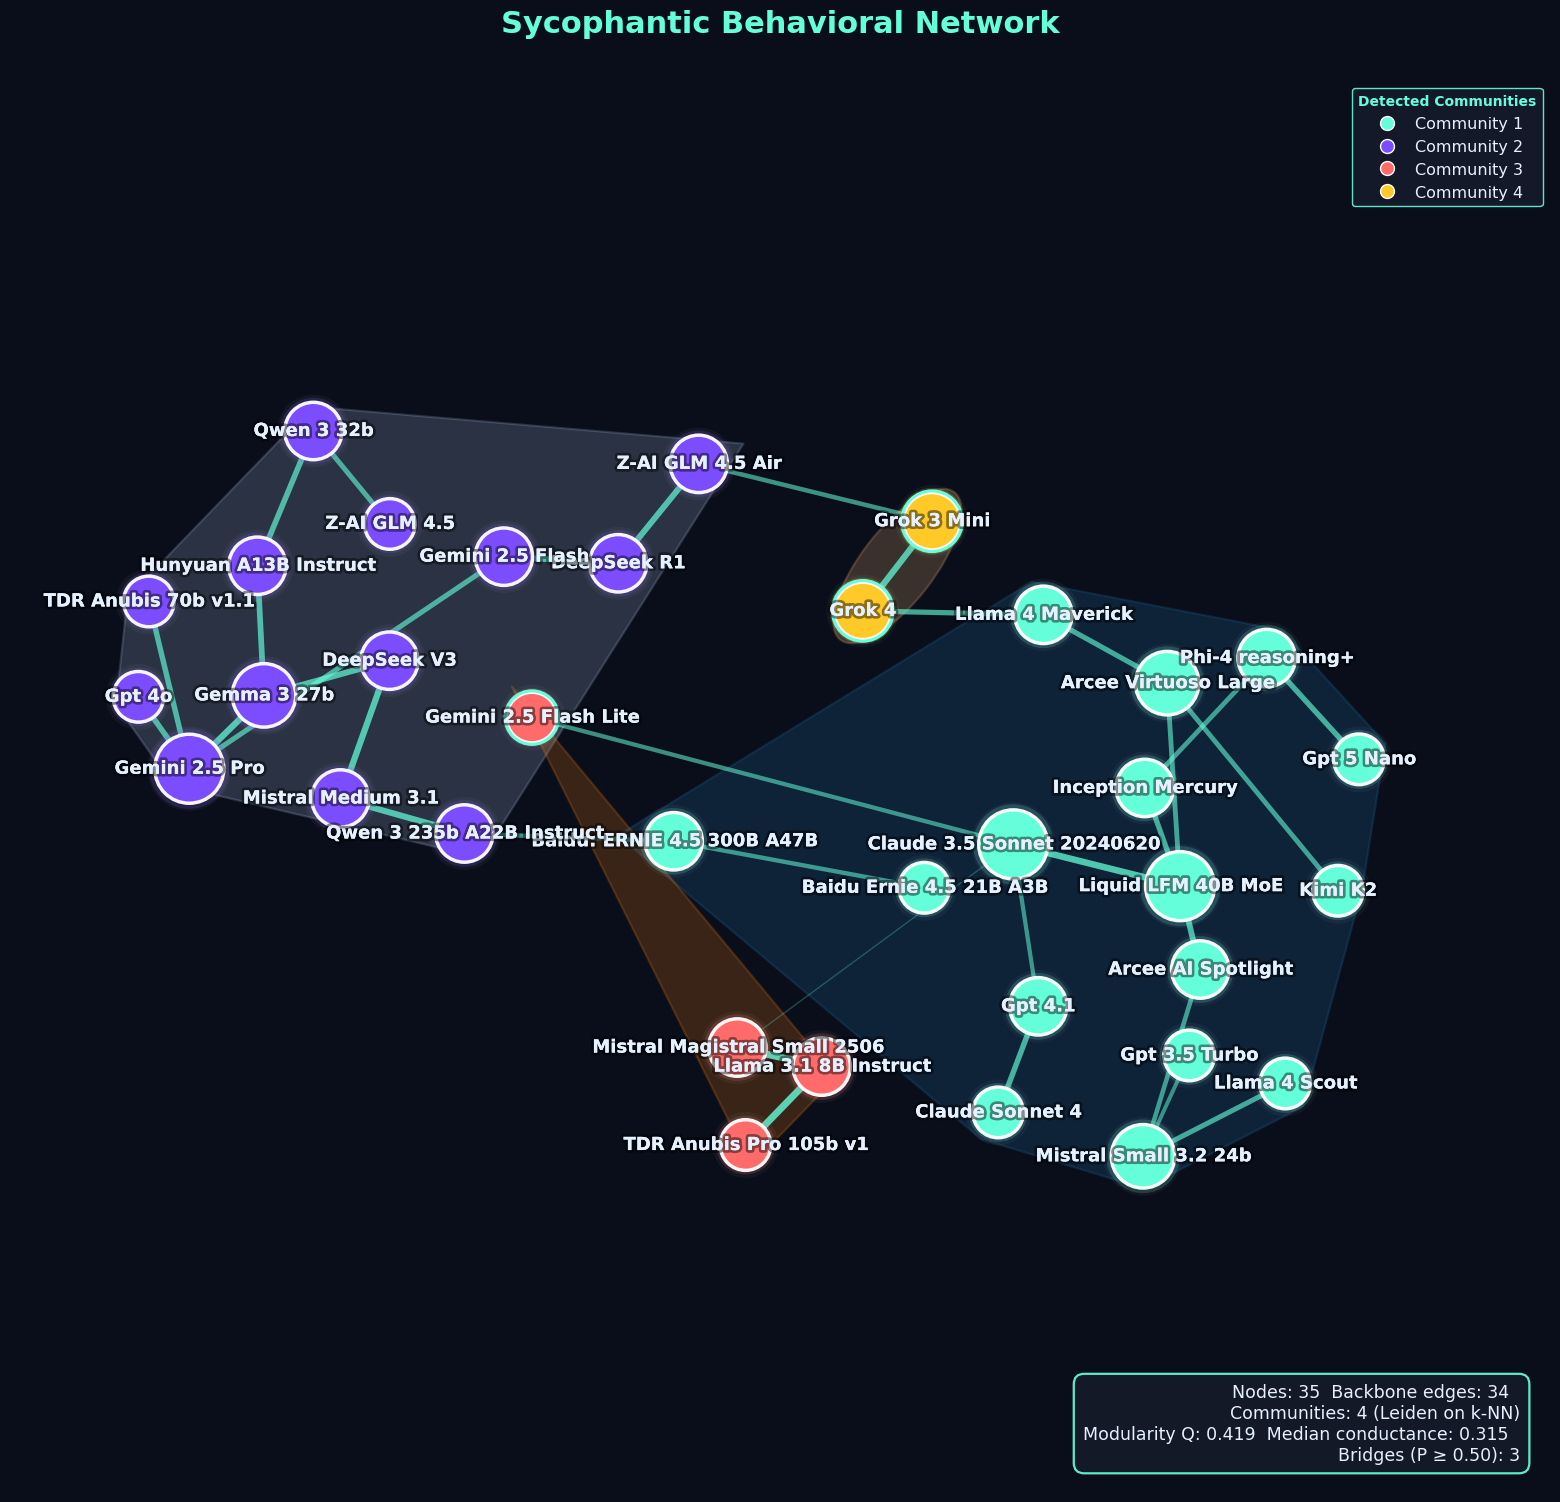

In [32]:
# Cell 2: example usage inside your notebook
import matplotlib.pyplot as plt
from sycophancy_analysis.visualization import plot_network  # your existing func

# ---- load or re-use your existing data ----
# names, S, pos, G_backbone, node_to_comm, Q, conductance, participation = ...

fig = plot_network(
    names, S, pos, G_backbone, node_to_comm,
    Q=Q, conductance=conductance, participation=participation,
    title="Sycophantic Behavioral Network"
)

ax = fig.axes[0]

# map community id -> color (reuse your palette if you prefer)
comm_ids = sorted(set(node_to_comm.values()))
comm_colors = {cid: plt.cm.tab20(i % 20) for i, cid in enumerate(comm_ids)}

draw_community_clouds(
    ax, pos, node_to_comm, comm_colors,
    padding=0.12,   # increase if clouds feel tight
    alpha=0.2,     # increase to make clouds more prominent
    split_far=True, # enable subclouds for far-out members (your Community 3 case)
    eps_frac=0.05   # increase if subclouds still merge; decrease if they split too much
)

plt.show()

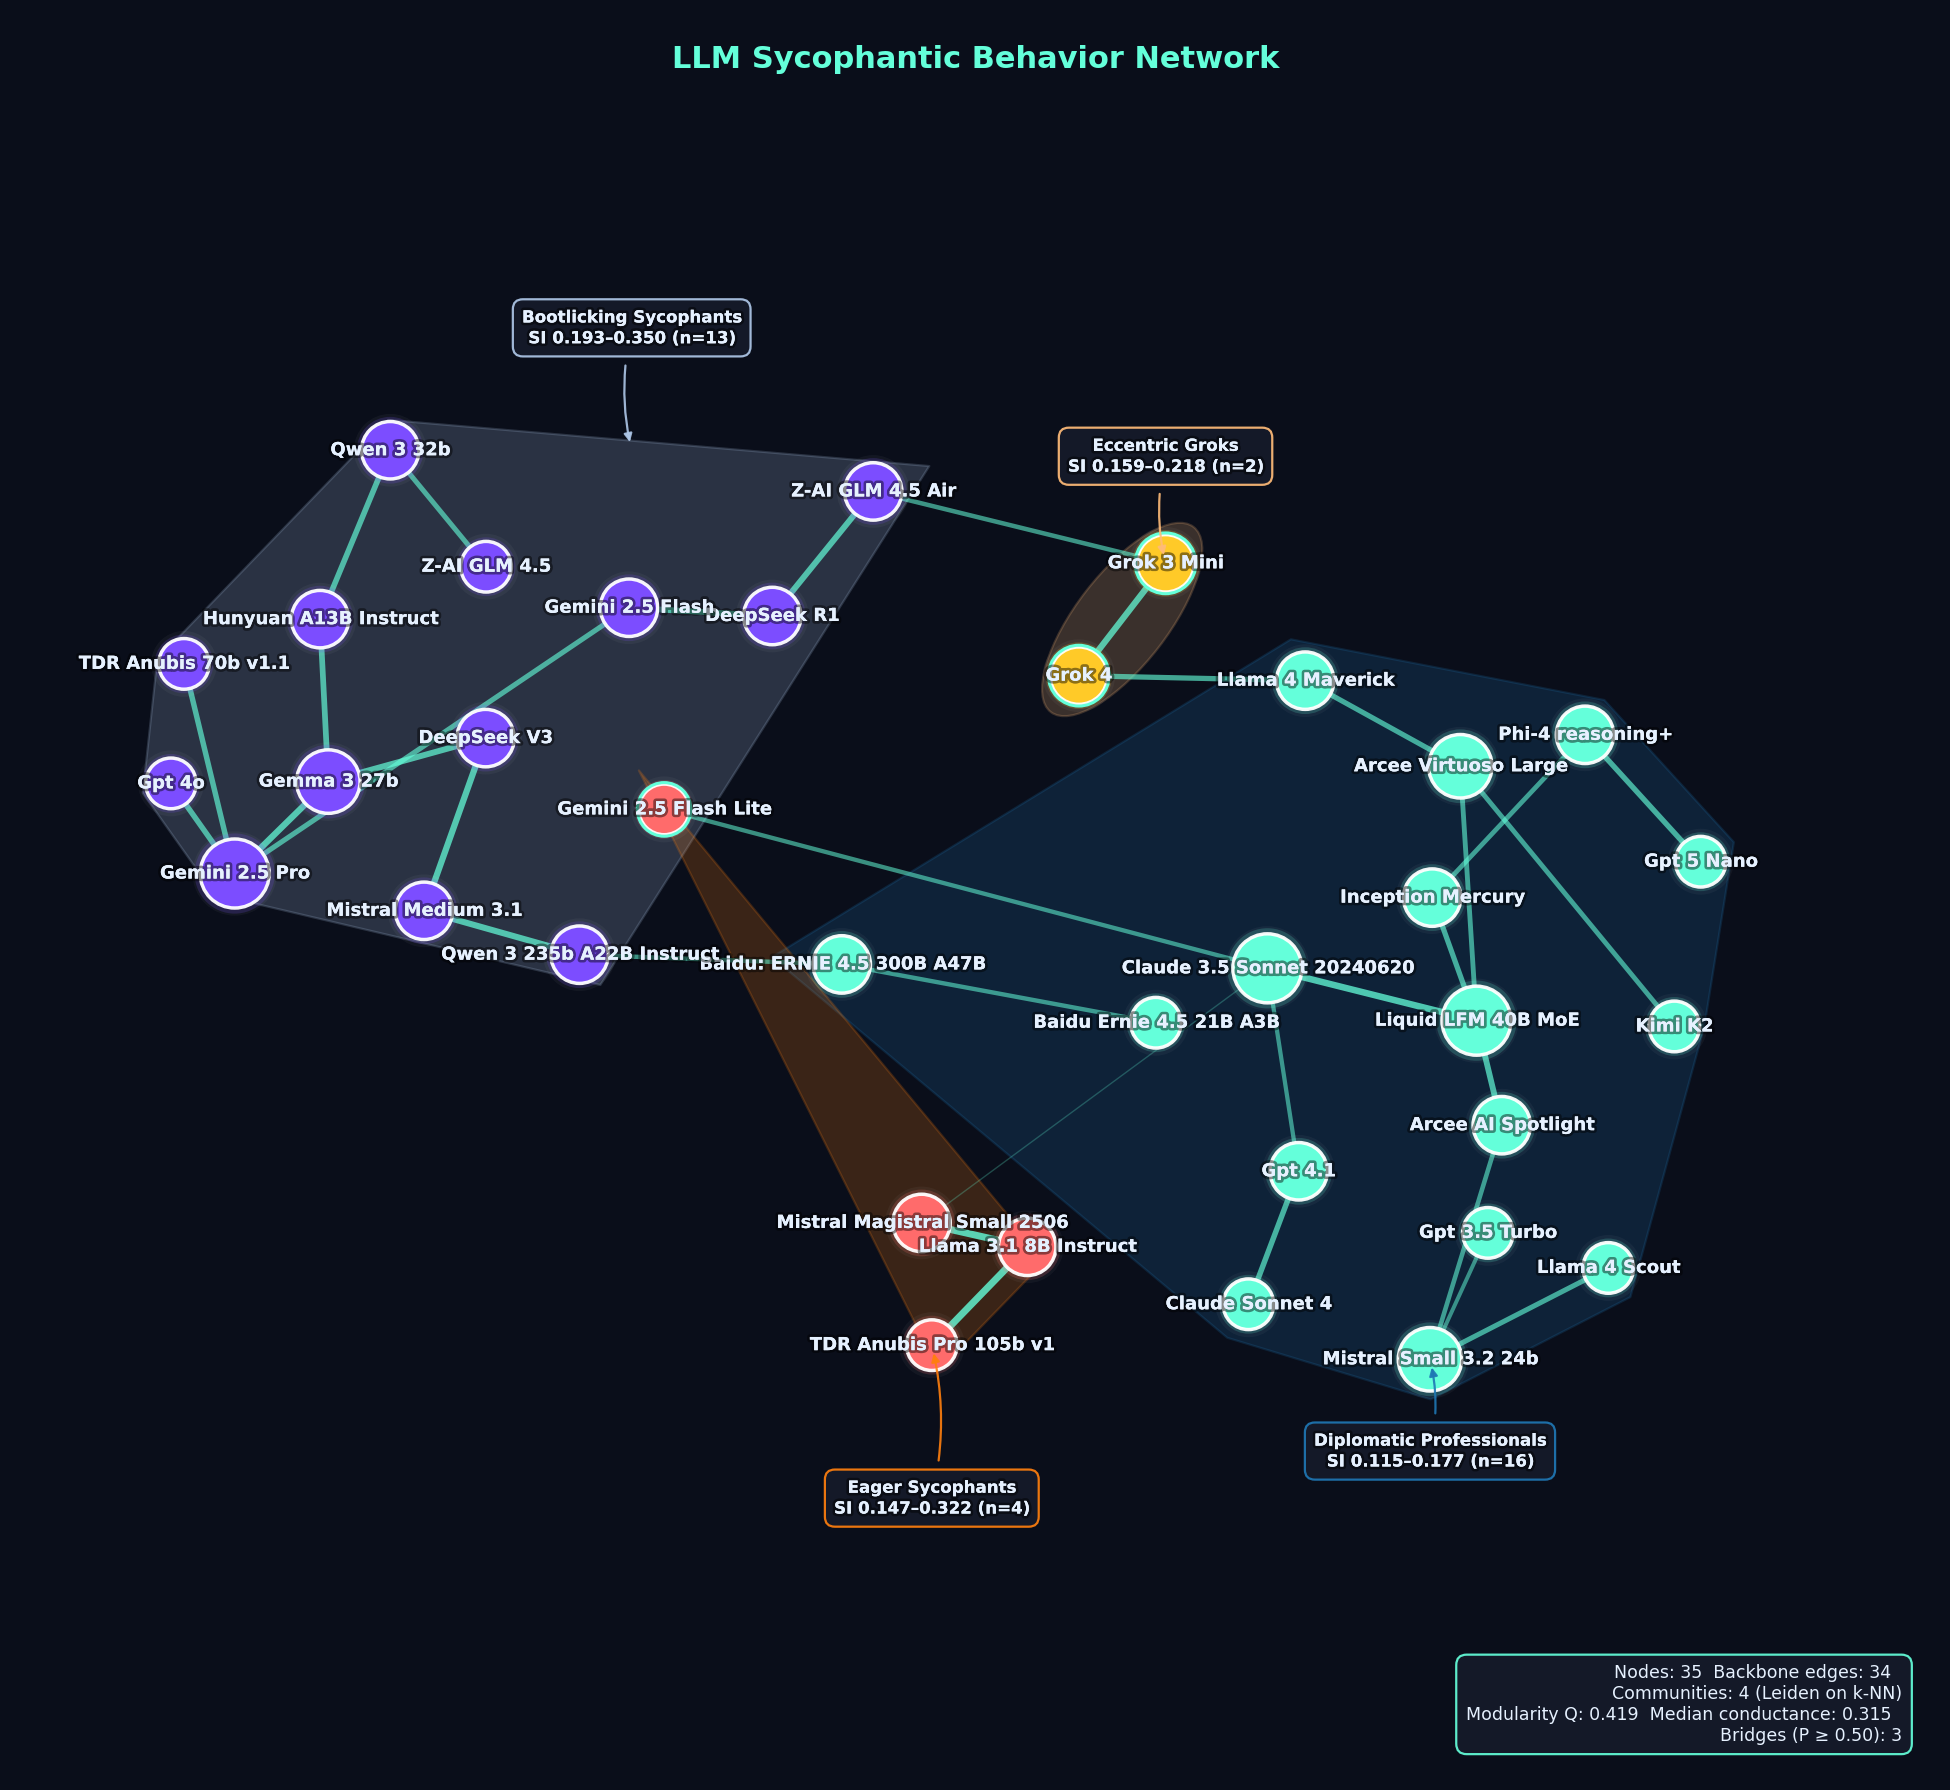

In [97]:
# Cell: label clouds by community id with custom names and SI ranges
import numpy as np
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt

def _plot_extent_scale(pos: dict[str, tuple[float, float]]) -> float:
    xs = np.array([p[0] for p in pos.values()])
    ys = np.array([p[1] for p in pos.values()])
    return float(max(xs.max()-xs.min(), ys.max()-ys.min()))

def _anchor_outside(points: np.ndarray, scale: float, side: str, margin_frac: float):
    """
    Returns (label_xy, target_xy) just outside the cluster in the given direction.
    side:
      axes: 'top'/'t'/'n', 'bottom'/'b'/'s', 'right'/'r'/'e', 'left'/'l'/'w'
      corners: 'top-right'/'tr'/'ne', 'top-left'/'tl'/'nw',
               'bottom-right'/'br'/'se', 'bottom-left'/'bl'/'sw'
    """
    if len(points) == 0:
        return None, None
    hull = _convex_hull(points) if len(points) >= 3 else np.asarray(points, dtype=float)
    margin = margin_frac * scale

    s = side.lower().replace("_","-")
    corner_dirs = {
        "top-right": (1, 1), "tr": (1, 1), "ne": (1, 1),
        "top-left": (-1, 1), "tl": (-1, 1), "nw": (-1, 1),
        "bottom-right": (1, -1), "br": (1, -1), "se": (1, -1),
        "bottom-left": (-1, -1), "bl": (-1, -1), "sw": (-1, -1),
    }
    axis_dirs = {
        "top": (0, 1), "t": (0, 1), "n": (0, 1),
        "bottom": (0, -1), "b": (0, -1), "s": (0, -1),
        "right": (1, 0), "r": (1, 0), "e": (1, 0),
        "left": (-1, 0), "l": (-1, 0), "w": (-1, 0),
    }

    if s in corner_dirs:
        dx, dy = corner_dirs[s]
        d = np.array([dx, dy], dtype=float)
        d = d / np.linalg.norm(d)
        # pick hull point farthest along d
        idx = int(np.argmax(hull @ d))
        target = hull[idx]
        label = target + d * margin
        return tuple(label), tuple(target)

    if s in axis_dirs:
        dx, dy = axis_dirs[s]
        d = np.array([dx, dy], dtype=float)
        # axis placement with stable median along orthogonal axis
        if dy == 1:   # top
            y = float(np.max(hull[:,1]))
            mask = np.isclose(hull[:,1], y, atol=0.03 * scale)
            x = float(np.median(hull[mask,0] if np.any(mask) else hull[:,0]))
            target = np.array([x, y])
        elif dy == -1:  # bottom
            y = float(np.min(hull[:,1]))
            mask = np.isclose(hull[:,1], y, atol=0.03 * scale)
            x = float(np.median(hull[mask,0] if np.any(mask) else hull[:,0]))
            target = np.array([x, y])
        elif dx == 1:  # right
            x = float(np.max(hull[:,0]))
            mask = np.isclose(hull[:,0], x, atol=0.03 * scale)
            y = float(np.median(hull[mask,1] if np.any(mask) else hull[:,1]))
            target = np.array([x, y])
        else:           # left
            x = float(np.min(hull[:,0]))
            mask = np.isclose(hull[:,0], x, atol=0.03 * scale)
            y = float(np.median(hull[mask,1] if np.any(mask) else hull[:,1]))
            target = np.array([x, y])
        label = target + d * margin
        return tuple(label), tuple(target)

    # default: top
    return _anchor_outside(points, scale, "top", margin_frac)

def draw_cloud_labels_outside(
    ax,
    pos: dict,                     # {node: (x,y)}
    node_to_comm: dict,            # {node: cid}
    comm_colors: dict,             # {cid: color}
    cloud_meta: dict,              # {cid: (name, "SI a–b")}
    *,
    side: str = 'top',
    margin_frac: float = 0.06,
    fontsize: int = 12,
    box_face: str = "#151B2A",
    text_color: str = "#E6F1FF"
):
    scale = _extent_scale(pos)
    for cid, (name, si_range) in cloud_meta.items():
        members = [n for n, c in node_to_comm.items() if c == cid]
        if not members:
            continue
        pts = np.array([pos[n] for n in members], dtype=float)
        label_xy, target_xy = _anchor_outside(pts, scale, side, margin_frac)
        if label_xy is None:
            continue
        edge_col = comm_colors.get(cid, (0.9,0.9,0.9,1.0))
        text = f"{name}\n{si_range} (n={len(members)})"
        ann = ax.annotate(
            text,
            xy=target_xy, xycoords='data',
            xytext=label_xy, textcoords='data',
            ha='center', va='center',
            fontsize=fontsize, fontweight='bold', color=text_color,
            bbox=dict(
                boxstyle="round,pad=0.55,rounding_size=0.6",
                facecolor=box_face, alpha=0.92,
                edgecolor=edge_col, linewidth=1.6,
            ),
            arrowprops=dict(
                arrowstyle="-|>", color=edge_col, lw=1.6,
                shrinkA=6, shrinkB=6, connectionstyle="arc3,rad=0.12",
                alpha=0.9
            ),
            zorder=4.1
        )
        ann.set_path_effects([pe.withStroke(linewidth=4, foreground=(0,0,0,0.45)), pe.Normal()])

def draw_cloud_labels(
    ax,
    pos: dict[str, tuple[float, float]],
    node_to_comm: dict[str, int],
    comm_colors: dict[int, tuple],
    cloud_meta: dict[int, tuple[str, str]],  # {cid: (name, "SI a–b")}
    *,
    offset_frac: float = 0.05,   # vertical offset in fraction of plot extent
    fontsize: int = 12,
    box_face: str = "#151B2A",
    text_color: str = "#E6F1FF"
):
    scale = _plot_extent_scale(pos)
    offset = offset_frac * scale

    for cid, (name, si_range) in cloud_meta.items():
        # members and centroid (robust median)
        members = [n for n, c in node_to_comm.items() if c == cid]
        if not members:
            continue
        xs = np.array([pos[n][0] for n in members], dtype=float)
        ys = np.array([pos[n][1] for n in members], dtype=float)
        cx, cy = float(np.median(xs)), float(np.median(ys)) + offset

        # build label text with dynamic (n)
        label = f"{name}\n{si_range} (n={len(members)})"
        edge_col = comm_colors.get(cid, (0.9, 0.9, 0.9, 1.0))

        t = ax.text(
            cx, cy, label,
            ha="center", va="center",
            fontsize=fontsize, fontweight="bold",
            color=text_color, zorder=4.0,
            bbox=dict(
                boxstyle="round,pad=0.55,rounding_size=0.6",
                facecolor=box_face, alpha=0.92,
                edgecolor=edge_col, linewidth=1.6,
            )
        )
        # subtle glow for readability on dark background
        t.set_path_effects([pe.withStroke(linewidth=4, foreground=(0, 0, 0, 0.45)), pe.Normal()])

fig = plot_network(
    names, S, pos, G_backbone, node_to_comm,
    Q=Q, conductance=conductance, participation=participation,
    title="LLM Sycophantic Behavior Network"
)
ax = fig.axes[0]


# map community id -> color (reuse your palette if you prefer)
comm_ids = sorted(set(node_to_comm.values()))
comm_colors = {cid: plt.cm.tab20(i % 20) for i, cid in enumerate(comm_ids)}

draw_community_clouds(
    ax, pos, node_to_comm, comm_colors,
    padding=0.12,   # increase if clouds feel tight
    alpha=0.2,     # increase to make clouds more prominent
    split_far=True, # enable subclouds for far-out members (your Community 3 case)
    eps_frac=0.05   # increase if subclouds still merge; decrease if they split too much
)


# plt.show()

# Build comm_colors if needed
if 'comm_colors' not in locals():
    comm_ids = sorted(set(node_to_comm.values()))
    comm_colors = {cid: plt.cm.tab20(i % 20) for i, cid in enumerate(comm_ids)}

cloud_meta = {
    0: ("Diplomatic Professionals", "SI 0.115–0.177"),
    1: ("Bootlicking Sycophants", "SI 0.193–0.350"),
    2: ("Eager Sycophants", "SI 0.147–0.322"),
    3: ("Eccentric Groks", "SI 0.159–0.218")
}


cm = cloud_meta  

# 0: top
draw_cloud_labels_outside(ax, pos, node_to_comm, comm_colors, {0: cm[0]},
                          side='bottom', margin_frac=0.06, fontsize=12)

# 1: right
draw_cloud_labels_outside(ax, pos, node_to_comm, comm_colors, {1: cm[1]},
                          side='top', margin_frac=0.08, fontsize=12)

# 2: right (a bit farther)
draw_cloud_labels_outside(ax, pos, node_to_comm, comm_colors, {2: cm[2]},
                          side='bottom', margin_frac=0.10, fontsize=12)

# 3: left
draw_cloud_labels_outside(ax, pos, node_to_comm, comm_colors, {3: cm[3]},
                          side='top', margin_frac=0.07, fontsize=12)

# Remove axes-level legends
for ax in fig.axes:
    leg = ax.get_legend()
    if leg: leg.remove()
# Remove any figure-level legends
for leg in list(fig.legends):
    leg.remove()

plt.show()